<h1 style="text-align:center;padding:1px">코로나 이후 영화 박스오피스 매출 분석</h1>

<h3 style="text-align:center;padding:1px">- KOBIS 영화관 입장권 통합 전산망 오픈 API 데이터 활용 -</h2>

------------------------

In [1]:
import requests
import json
import datetime as dt
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 그래프 스타일 지정
style.use('seaborn') 
sns.set_style('darkgrid')

# 그래프에 한글 폰트가 보이도록 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
    
# 출력할 열과 행의 최대 개수 설정
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

### - 가설 설정

<img src="https://imgnews.pstatic.net/image/001/2021/01/16/GYH2021011600040004400_P2_20210116114434038.jpg?type=w647" width="600">

- 2020년 2월 말 ~ 3월을 코로나19 1차 대유행, 2020년 8월 말 ~ 9월을 2차 대유행, 2020년 12월 ~ 2021년 1월 초를 3차 대유행으로 정의한다.
- 이 기간동안의 영화 매출액을 전년도와 비교해보면 50% 이상 대폭 하락했을 것이다. 
- 대유행 시기 중 일별 신규 확진자 수가 최고치를 기록한 직후에 영화 매출액이 가장 크게 급감했을 것이다.  
- 1, 2, 3차 대유행 시기의 영화 매출액 하락률을 서로 비교해보았을 때, 가장 큰 하락률을 보인 기간은 1차 > 2차 > 3차 순서일 것이다. 
- 즉, 영화 매출 하락은 시간이 경과할수록 점차 회복해가는 추세를 띨 것이다. 

### - 데이터 수집 전 준비작업

영화관 입장권 통합 전산망 [KOBIS](http://www.kobis.or.kr/kobisopenapi/homepg/apiservice/searchServiceInfo.do?serviceId=searchDailyBoxOffice) 에서 제공하는 데이터는 다음과 같다.

- 박스오피스 - 일별 박스오피스, 주간/주말 박스오피스
- 영화정보 - 영화 목록, 영화 상세정보
- 영화사정보 - 영화사 목록, 영화사 상세정보
- 영화인정보 - 영화인 목록, 영화인 상세정보

이번 프로젝트에서는 "일별 박스오피스 데이터"를 REST 방식으로 가져와 분석해보려고 한다. 

#### 사이트 회원가입 후 key 발급

In [2]:
key = "046fdd8b8b0616dba99b0fcd7aac3db4"

#### 세션 생성

In [3]:
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36"
session = requests.Session()
session.headers.update({'User-agent':user_agent, 'referer':None})

### - 전날 박스오피스 데이터 불러와보기

KOBIS는 전날까지 축적된 데이터를 제공한다. 우선 어제 하루분에 해당하는 데이터를 불러와 살펴본다. (2021.01.26. 기준)

#### 조회하고자 하는 날짜 지정

In [15]:
today = dt.datetime.now() # 오늘 날짜                      
delta = dt.timedelta(days=-1) # 날짜 연산을 위한 delta 
yesterday = today + delta                    
yesterday_str = yesterday.strftime('%Y%m%d') # 날짜를 yyyymmdd 형식의 문자열로 변환

yesterday_str

'20210125'

#### 요청 URL 주소 생성

In [16]:
url = f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key={key}&targetDt={yesterday_str}"
# key={} 부분에는 발급받은 키 값을, 
# targetDt={} 부분에는 조회하고자 하는 날짜를 yyyymmdd 형식으로 입력하도록 홈페이지에 안내되어있음.

url 

'http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key=046fdd8b8b0616dba99b0fcd7aac3db4&targetDt=20210125'

#### JSON 형식으로 가져오기

JSONView 확장 프로그램을 설치하면 좀 더 보기좋게 정렬이 가능하다. --- 설치완료

In [17]:
api = session.get(url) # 앞서 생성한 URL 주소를 ()안에 입력
api.encoding = "utf-8" # 한글 문자열을 제대로 출력하기 위함

if api.status_code != 200: # api.status_code가 200이면 요청이 정상적으로 처리된 것. 아닐 시 "ERROR"를 출력하고 실행을 멈추라는 코드.
    print("ERROR")
    quit()

api.text

'{"boxOfficeResult":{"boxofficeType":"일별 박스오피스","showRange":"20210125~20210125","dailyBoxOfficeList":[{"rnum":"1","rank":"1","rankInten":"0","rankOldAndNew":"OLD","movieCd":"20207443","movieNm":"소울","openDt":"2021-01-20","salesAmt":"405787650","salesShare":"86.5","salesInten":"-763382140","salesChange":"-65.3","salesAcc":"4172643150","audiCnt":"45020","audiInten":"-79864","audiChange":"-64","audiAcc":"453522","scrnCnt":"1707","showCnt":"5143"},{"rnum":"2","rank":"2","rankInten":"1","rankOldAndNew":"OLD","movieCd":"20202540","movieNm":"커넥트","openDt":"2021-01-20","salesAmt":"7916930","salesShare":"1.7","salesInten":"-16708490","salesChange":"-67.9","salesAcc":"108555970","audiCnt":"921","audiInten":"-1770","audiChange":"-65.8","audiAcc":"12124","scrnCnt":"256","showCnt":"358"},{"rnum":"3","rank":"3","rankInten":"2","rankOldAndNew":"OLD","movieCd":"20040725","movieNm":"화양연화","openDt":"2000-10-20","salesAmt":"7281510","salesShare":"1.6","salesInten":"-4861340","salesChange":"-40","salesAcc

#### 딕셔너리로 변환

가독성을 위해 JSON 형식의 데이터를 딕셔너리 형태로 변환해본다.

In [18]:
dbo_dict = json.loads(api.text) 

dbo_dict

{'boxOfficeResult': {'boxofficeType': '일별 박스오피스',
  'showRange': '20210125~20210125',
  'dailyBoxOfficeList': [{'rnum': '1',
    'rank': '1',
    'rankInten': '0',
    'rankOldAndNew': 'OLD',
    'movieCd': '20207443',
    'movieNm': '소울',
    'openDt': '2021-01-20',
    'salesAmt': '405787650',
    'salesShare': '86.5',
    'salesInten': '-763382140',
    'salesChange': '-65.3',
    'salesAcc': '4172643150',
    'audiCnt': '45020',
    'audiInten': '-79864',
    'audiChange': '-64',
    'audiAcc': '453522',
    'scrnCnt': '1707',
    'showCnt': '5143'},
   {'rnum': '2',
    'rank': '2',
    'rankInten': '1',
    'rankOldAndNew': 'OLD',
    'movieCd': '20202540',
    'movieNm': '커넥트',
    'openDt': '2021-01-20',
    'salesAmt': '7916930',
    'salesShare': '1.7',
    'salesInten': '-16708490',
    'salesChange': '-67.9',
    'salesAcc': '108555970',
    'audiCnt': '921',
    'audiInten': '-1770',
    'audiChange': '-65.8',
    'audiAcc': '12124',
    'scrnCnt': '256',
    'showCnt': '3

#### 데이터프레임으로 변환

데이터 분석을 위해 딕셔너리 형태의 데이터를 데이터프레임 형식으로 변환시켜준다.

In [19]:
dbo_df = DataFrame(dbo_dict['boxOfficeResult']['dailyBoxOfficeList'])

dbo_df

,rnum,rank,rankInten,rankOldAndNew,movieCd,movieNm,openDt,salesAmt,salesShare,salesInten,salesChange,salesAcc,audiCnt,audiInten,audiChange,audiAcc,scrnCnt,showCnt
0,1,1,0,OLD,20207443,소울,2021-01-20,405787650,86.5,-763382140,-65.3,4172643150,45020,-79864,-64,453522,1707,5143
1,2,2,1,OLD,20202540,커넥트,2021-01-20,7916930,1.7,-16708490,-67.9,108555970,921,-1770,-65.8,12124,256,358
2,3,3,2,OLD,20040725,화양연화,2000-10-20,7281510,1.6,-4861340,-40,850804160,820,-470,-36.4,97055,201,240
3,4,4,0,OLD,20192567,원더 우먼 1984,2020-12-23,5245550,1.1,-10987240,-67.7,4920345200,606,-1206,-66.6,544794,214,244
4,5,5,7,OLD,20078386,블라인드,2021-01-14,3727200,0.8,-2326600,-38.4,142456400,487,-173,-26.2,16081,128,162
5,6,6,0,OLD,20202924,파힘,2021-01-21,3420700,0.7,-5790300,-62.9,39358000,442,-581,-56.8,5143,114,168
6,7,7,0,OLD,20201122,테넷,2020-08-26,3835800,0.8,-4550300,-54.3,18436575170,384,-456,-54.3,1996217,20,52
7,8,8,2,OLD,20204504,모추어리 컬렉션,2021-01-21,1985300,0.4,-4736500,-70.5,27518300,220,-516,-70.1,3212,79,105
8,9,9,4,OLD,20201648,더 시크릿,2021-01-21,1470620,0.3,-1864050,-55.9,13773560,213,-241,-53.1,1886,51,62
9,10,10,6,OLD,20214963,큰엄마의 미친봉고,2021-01-21,1428550,0.3,-1643310,-53.5,13067230,207,-208,-50.1,1818,48,59


→ 어제 하루분의 데이터가 올바르게 잘 불러와지는 것을 확인했다. 이제 일정기간 동안의 데이터를 불러오기 위한 반복문을 만들어볼 차례.

### - 데이터를 불러와 전처리하는 함수 만들기

def문으로 함수를 만들어두면 데이터를 불러와 전처리하는 코드가 간결해진다. 

#### for in 반복문 만들기

함수를 만들기에 앞서, 반복문을 만들어 기본적인 틀을 짜본다. 지난 일주일(2021.01.26.기준)간 축적된 데이터를 불러와 영화별 매출액을 보여주는 데이터프레임을 생성하기 위한 반복문을 만든다.

In [20]:
kobis_df = DataFrame()

for d in range(-4, 3):
    
    t = dt.datetime.strptime(str(20210123), '%Y%m%d')
    delta = dt.timedelta(days=d)   
    period = t + delta                    
    period_str = period.strftime('%Y%m%d')                   
    
    url = f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key={key}&targetDt={period_str}"
       
    api = session.get(url)
    api.encoding = 'utf-8'
        
    if api.status_code != 200:
        print("ERROR")
        continue

    dbo_dict = json.loads(api.text) 
    dbo_df = DataFrame(dbo_dict['boxOfficeResult']['dailyBoxOfficeList'])
    
    # 영화명과 매출액 column만 남기고 나머지 불필요한 열 삭제
    dbo_df_drop = dbo_df[['movieNm', 'salesAmt']]
    
    # 영화명을 list로 저장한 후 각각에 대해 index 값 붙여주기
    movieNm_list = list(dbo_df_drop['movieNm'])
    movieNm_dict = {}
    for m, y in enumerate(movieNm_list): # list에 들어있는 각 객체가 어느 위치(인덱스 값)에 있는지 열거해주는 enumerate 함수
        movieNm_dict[m] = y
        
    # column 이름 변경 (매출액 column --> 조회하고자 하는 날짜로 변경)
    dbo_df_new = dbo_df_drop.rename(index=movieNm_dict, columns={'salesAmt': period_str})

    # 매출액 값을 모두 정수형으로 변환
    dbo_df_new[period_str] = dbo_df_new[period_str].apply(pd.to_numeric) 
    
    # 불필요해진 movieNm 칼럼 제거 
    dbo_df_new.drop('movieNm', axis=1, inplace=True)

    # 영화명(index)이 동일한 데이터를 기준으로 누적한 sample_df 완성
    kobis_df = pd.merge(kobis_df, dbo_df_new, # 두 데이터프레임을 병합할 때 사용하는 merge 함수
                        how="outer", # 병합하는 두 데이터프레임 중 어느 한쪽에 데이터가 없는 행이 있더라도 모두 출력 
                        left_index=True, right_index=True) # 일반 데이터 열이 아닌 index를 기준 열로 사용할 떄

kobis_df

,20210119,20210120,20210121,20210122,20210123,20210124,20210125
#아이엠히어,9017100.0,3378920.0,NaN,NaN,NaN,NaN,NaN
극장판 귀멸의 칼날: 무한열차편,NaN,NaN,NaN,4174740.0,5.028655e+07,5.052351e+07,NaN
나는 나를 해고하지 않는다,NaN,3493000.0,10500000.0,NaN,NaN,NaN,NaN
늑대와 춤을,4656900.0,NaN,NaN,3598100.0,NaN,NaN,NaN
더 시크릿,NaN,NaN,2714010.0,NaN,NaN,NaN,1470620.0
도굴,3479800.0,NaN,NaN,NaN,NaN,NaN,NaN
라스트 프론티어,NaN,NaN,NaN,NaN,2.562000e+06,3.850000e+06,NaN
래시 컴 홈,NaN,2683500.0,NaN,NaN,NaN,NaN,NaN
마이 미씽 발렌타인,3139500.0,NaN,NaN,NaN,NaN,NaN,NaN
모추어리 컬렉션,NaN,NaN,6567600.0,5041000.0,7.202600e+06,6.721800e+06,1985300.0


→ 날짜별, 영화별로 매출액을 확인할 수 있는 데이터프레임이 완성되었다. 추가적인 전처리 작업을 통해 데이터프레임을 편집해보자.

#### 전치행렬 처리

데이터프레임의 행과 열을 서로 바꿔주어 한눈에 보기 좋도록 한다.

In [21]:
kobis_df = kobis_df.T

kobis_df

,#아이엠히어,극장판 귀멸의 칼날: 무한열차편,나는 나를 해고하지 않는다,늑대와 춤을,더 시크릿,도굴,라스트 프론티어,래시 컴 홈,마이 미씽 발렌타인,모추어리 컬렉션,블라인드,세자매,소울,아이 엠 우먼,원더 우먼 1984,인터스텔라,커넥트,큰엄마의 미친봉고,테넷,파힘,화양연화
20210119,9017100.0,NaN,NaN,4656900.0,NaN,3479800.0,NaN,NaN,3139500.0,NaN,8681700.0,3386000.0,NaN,8521510.0,16448800.0,3359500.0,NaN,NaN,NaN,NaN,11637900.0
20210120,3378920.0,NaN,3493000.0,NaN,NaN,NaN,NaN,2683500.0,NaN,NaN,5423900.0,NaN,5.295299e+08,5239970.0,8385220.0,NaN,21819980.0,NaN,4898970.0,NaN,8356370.0
20210121,NaN,NaN,10500000.0,NaN,2714010.0,NaN,NaN,NaN,NaN,6567600.0,4163800.0,NaN,3.807046e+08,NaN,6476850.0,NaN,13230830.0,NaN,4485500.0,9648000.0,6496380.0
20210122,NaN,4174740.0,NaN,3598100.0,NaN,NaN,NaN,NaN,NaN,5041000.0,4638500.0,NaN,4.488570e+08,NaN,7040870.0,NaN,14690260.0,NaN,4740440.0,6847700.0,8360380.0
20210123,NaN,50286550.0,NaN,NaN,NaN,NaN,2562000.0,NaN,NaN,7202600.0,7363200.0,NaN,1.227702e+09,NaN,16092280.0,NaN,25633550.0,NaN,10048000.0,9190600.0,13565660.0
20210124,NaN,50523510.0,NaN,NaN,NaN,NaN,3850000.0,NaN,NaN,6721800.0,NaN,NaN,1.169170e+09,6511300.0,16232790.0,NaN,24625420.0,NaN,8386100.0,9211000.0,12142850.0
20210125,NaN,NaN,NaN,NaN,1470620.0,NaN,NaN,NaN,NaN,1985300.0,3727200.0,NaN,4.057876e+08,NaN,5245550.0,NaN,7916930.0,1428550.0,3835800.0,3420700.0,7281510.0


#### 결측치 처리

개봉을 아직 하지않은 영화들에 대해서는 매출액이 도출될 수 없다. 따라서 이러한 결측치들은 모두 0으로 대체해준다. 

In [22]:
kobis_df = kobis_df.fillna(0)

kobis_df

,#아이엠히어,극장판 귀멸의 칼날: 무한열차편,나는 나를 해고하지 않는다,늑대와 춤을,더 시크릿,도굴,라스트 프론티어,래시 컴 홈,마이 미씽 발렌타인,모추어리 컬렉션,블라인드,세자매,소울,아이 엠 우먼,원더 우먼 1984,인터스텔라,커넥트,큰엄마의 미친봉고,테넷,파힘,화양연화
20210119,9017100.0,0.0,0.0,4656900.0,0.0,3479800.0,0.0,0.0,3139500.0,0.0,8681700.0,3386000.0,0.000000e+00,8521510.0,16448800.0,3359500.0,0.0,0.0,0.0,0.0,11637900.0
20210120,3378920.0,0.0,3493000.0,0.0,0.0,0.0,0.0,2683500.0,0.0,0.0,5423900.0,0.0,5.295299e+08,5239970.0,8385220.0,0.0,21819980.0,0.0,4898970.0,0.0,8356370.0
20210121,0.0,0.0,10500000.0,0.0,2714010.0,0.0,0.0,0.0,0.0,6567600.0,4163800.0,0.0,3.807046e+08,0.0,6476850.0,0.0,13230830.0,0.0,4485500.0,9648000.0,6496380.0
20210122,0.0,4174740.0,0.0,3598100.0,0.0,0.0,0.0,0.0,0.0,5041000.0,4638500.0,0.0,4.488570e+08,0.0,7040870.0,0.0,14690260.0,0.0,4740440.0,6847700.0,8360380.0
20210123,0.0,50286550.0,0.0,0.0,0.0,0.0,2562000.0,0.0,0.0,7202600.0,7363200.0,0.0,1.227702e+09,0.0,16092280.0,0.0,25633550.0,0.0,10048000.0,9190600.0,13565660.0
20210124,0.0,50523510.0,0.0,0.0,0.0,0.0,3850000.0,0.0,0.0,6721800.0,0.0,0.0,1.169170e+09,6511300.0,16232790.0,0.0,24625420.0,0.0,8386100.0,9211000.0,12142850.0
20210125,0.0,0.0,0.0,0.0,1470620.0,0.0,0.0,0.0,0.0,1985300.0,3727200.0,0.0,4.057876e+08,0.0,5245550.0,0.0,7916930.0,1428550.0,3835800.0,3420700.0,7281510.0


#### 지수형 수치를 정수형으로 변환

직관적이지 않은 지수 형태의 수들을 모두 정수형으로 바꿔준다. 이 코드는 한 번만 실행해주면 뒤에 오는 모든 코드들에서도 똑같이 적용된다.

In [23]:
pd.options.display.float_format = '{:.0f}'.format # 반대의 경우 : pd.reset_option('display.float_format')

kobis_df

,#아이엠히어,극장판 귀멸의 칼날: 무한열차편,나는 나를 해고하지 않는다,늑대와 춤을,더 시크릿,도굴,라스트 프론티어,래시 컴 홈,마이 미씽 발렌타인,모추어리 컬렉션,블라인드,세자매,소울,아이 엠 우먼,원더 우먼 1984,인터스텔라,커넥트,큰엄마의 미친봉고,테넷,파힘,화양연화
20210119,9017100,0,0,4656900,0,3479800,0,0,3139500,0,8681700,3386000,0,8521510,16448800,3359500,0,0,0,0,11637900
20210120,3378920,0,3493000,0,0,0,0,2683500,0,0,5423900,0,529529910,5239970,8385220,0,21819980,0,4898970,0,8356370
20210121,0,0,10500000,0,2714010,0,0,0,0,6567600,4163800,0,380704610,0,6476850,0,13230830,0,4485500,9648000,6496380
20210122,0,4174740,0,3598100,0,0,0,0,0,5041000,4638500,0,448857040,0,7040870,0,14690260,0,4740440,6847700,8360380
20210123,0,50286550,0,0,0,0,2562000,0,0,7202600,7363200,0,1227702150,0,16092280,0,25633550,0,10048000,9190600,13565660
20210124,0,50523510,0,0,0,0,3850000,0,0,6721800,0,0,1169169790,6511300,16232790,0,24625420,0,8386100,9211000,12142850
20210125,0,0,0,0,1470620,0,0,0,0,1985300,3727200,0,405787650,0,5245550,0,7916930,1428550,3835800,3420700,7281510


#### 일별 매출액 합계 column 생성

각 날짜마다의 영화 매출액 합계를 보여주는 열을 추가한다. 

In [24]:
kobis_df['Sum'] = kobis_df.iloc[:,0:len(kobis_df.columns)].sum(axis=1) # len(kobis_df.columns)는 영화 개수

kobis_df

,#아이엠히어,극장판 귀멸의 칼날: 무한열차편,나는 나를 해고하지 않는다,늑대와 춤을,더 시크릿,도굴,라스트 프론티어,래시 컴 홈,마이 미씽 발렌타인,모추어리 컬렉션,블라인드,세자매,소울,아이 엠 우먼,원더 우먼 1984,인터스텔라,커넥트,큰엄마의 미친봉고,테넷,파힘,화양연화,Sum
20210119,9017100,0,0,4656900,0,3479800,0,0,3139500,0,8681700,3386000,0,8521510,16448800,3359500,0,0,0,0,11637900,72328710
20210120,3378920,0,3493000,0,0,0,0,2683500,0,0,5423900,0,529529910,5239970,8385220,0,21819980,0,4898970,0,8356370,593209740
20210121,0,0,10500000,0,2714010,0,0,0,0,6567600,4163800,0,380704610,0,6476850,0,13230830,0,4485500,9648000,6496380,444987580
20210122,0,4174740,0,3598100,0,0,0,0,0,5041000,4638500,0,448857040,0,7040870,0,14690260,0,4740440,6847700,8360380,507989030
20210123,0,50286550,0,0,0,0,2562000,0,0,7202600,7363200,0,1227702150,0,16092280,0,25633550,0,10048000,9190600,13565660,1369646590
20210124,0,50523510,0,0,0,0,3850000,0,0,6721800,0,0,1169169790,6511300,16232790,0,24625420,0,8386100,9211000,12142850,1307374560
20210125,0,0,0,0,1470620,0,0,0,0,1985300,3727200,0,405787650,0,5245550,0,7916930,1428550,3835800,3420700,7281510,442099810


#### 반복문을 활용한 함수 만들기

앞서 만든 반복문과 덧붙인 코드들을 이용하여, 기간(term)과 기준이 되는 날짜(date)를 입력하면 그에 해당하는 데이터를 불러와 데이터프레임을 생성해주는 create_a_kobis_df 함수를 만들어본다. 예를 들어, 2020년 11월 9일을 기준으로 전후 일주일에 해당하는 데이터가 궁금하다면 create_a_kobis_df(7, 20201109)를 실행하면 된다.

In [5]:
def create_a_kobis_df(term, date): 
    
    kobis_df = DataFrame()

    for d in range(-term, term):
    
        t = dt.datetime.strptime(str(date), '%Y%m%d')
        delta = dt.timedelta(days=d)   
        period = t + delta                    
        period_str = period.strftime('%Y%m%d')                   
    
        url = f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key={key}&targetDt={period_str}"
       
        api = session.get(url)
        api.encoding = 'utf-8'
        
        if api.status_code != 200:
            print("ERROR")
            continue

        dbo_dict = json.loads(api.text) 
        dbo_df = DataFrame(dbo_dict['boxOfficeResult']['dailyBoxOfficeList'])
    
        dbo_df_drop = dbo_df[['movieNm', 'salesAmt']]
    
        movieNm_list = list(dbo_df_drop['movieNm'])
        movieNm_dict = {}
        for m, y in enumerate(movieNm_list): 
            movieNm_dict[m] = y
        
        dbo_df_new = dbo_df_drop.rename(index=movieNm_dict, columns={'salesAmt': period_str})

        dbo_df_new[period_str] = dbo_df_new[period_str].apply(pd.to_numeric) 
        
        dbo_df_new.drop('movieNm', axis=1, inplace=True)
        
        kobis_df = pd.merge(kobis_df, dbo_df_new, 
                             how="outer", 
                             left_index=True, right_index=True) 
        
    kobis_df = kobis_df.T
    
    kobis_df = kobis_df.fillna(0)
    
    kobis_df['Sum'] = kobis_df.iloc[:,0:len(kobis_df.columns)].sum(axis=1)   

    return kobis_df

### - 코로나19로 인한 영화 매출 하략률 분석

코로나19 대유행 시기를 1차, 2차, 3차로 나누어 각 기간동안의 영화 매출 하략률을 분석하고, 이를 2019년 데이터와 비교해보고자 한다. 코로나19 신규 확진자 수가 최고치를 기록한 날을 기점으로 전후 2주간의 매출액을 비교해서 하락률을 파악한다. 데이터를 충분히 확보하고 한 달간의 흐름을 살펴보기에 2주라는 기간이 적당하다고 판단하였다.  

<img src="https://imgnews.pstatic.net/image/001/2021/01/16/GYH2021011600040004400_P2_20210116114434038.jpg?type=w647" width="600">

(1) 코로나 1차 대유행 시기 - 2020.02.29. 기점으로 전후 14일 비교

(2) 코로나 2차 대유행 시기 - 2020.08.27. 기점으로 전후 14일 비교

(3) 코로나 3차 대유행 시기 - 2020.12.25. 기점으로 전후 14일 비교

-------

#### (1) 코로나 1차 대유행 시기 - 2020.02.29. 기점으로 전후 14일 비교

#### 2020년 2월 15일 ~ 3월 13일 데이터 불러오기

In [7]:
feb2020 = create_a_kobis_df(14, 20200229)

feb2020

,1917,걸즈 앤 판처 최종장,그링고,극장판 미니특공대: 공룡왕 디노,극장판 원피스 스탬피드,기생충,남산의 부장들,다크 워터스,더 보이 2: 돌아온 브람스,메멘토,버즈 오브 프레이(할리 퀸의 황홀한 해방),숀더쉽 더 무비: 꼬마 외계인 룰라!,수퍼 소닉,스타 이즈 본,시원찮은 그녀를 위한 육성방법 피날레,신의 한 수: 귀수편,어바웃 타임,엠마,울프 콜,인비저블맨,작은 아씨들,장마,정직한 후보,젠틀맨,조조 래빗,지푸라기라도 잡고 싶은 짐승들,클로젯,"하이, 젝시",해리포터와 아즈카반의 죄수,히트맨,Sum
20200215,0,0,0,73960580,0,236727940,231859970,0,0,0,144030760,0,232057240,0,0,0,0,0,0,0,1105812170,0,2351194760,0,82980320,0,738139780,0,0,42351400,5239114920
20200216,0,0,0,83643860,0,226729200,213728320,0,0,0,116148660,0,246304450,0,0,0,0,0,0,0,935617190,0,2282525940,0,71573620,0,641461040,0,0,34564800,4852297080
20200217,0,0,0,0,12482360,77519240,75694380,0,0,0,50888700,0,49259260,0,0,0,0,0,0,0,400762690,0,740684200,0,33731760,0,232389480,0,0,15575220,1688987290
20200218,0,0,0,0,14659100,71541940,68233130,0,0,0,55313140,0,56709960,0,0,0,0,0,0,0,408590970,0,757265330,0,27490360,0,214709520,0,0,15765000,1690278450
20200219,539744600,0,0,0,0,46713600,0,0,0,0,0,31301200,19301400,0,0,0,0,0,0,0,287668200,0,509543380,0,15588520,635247390,107247480,62784000,0,0,2255139770
20200220,399837480,0,0,13292040,0,36746060,0,0,0,0,0,0,15795400,0,0,0,0,0,0,0,237342660,0,387119230,0,13698960,503421440,89796000,32932500,0,0,1729981770
20200221,425570420,0,0,0,0,28914240,0,0,0,0,0,8993360,13514380,0,0,0,0,0,0,0,222097570,0,351958260,0,15828080,531728160,78652040,26101000,0,0,1703357510
20200222,695995020,0,0,0,0,36180400,0,0,0,0,0,12278860,24779560,0,0,0,0,0,0,0,290738700,0,535526650,0,24372780,873605400,88406000,25587500,0,0,2607470870
20200223,519643080,0,0,0,0,24967120,0,0,0,0,0,8897080,16171160,0,0,0,0,0,0,0,198286630,0,384071320,0,19149180,642317060,65226000,23881500,0,0,1902610130
20200224,176264240,0,0,0,0,10504720,3080960,0,0,0,0,0,3124000,0,0,0,0,0,0,0,74066760,0,113350260,0,7756800,193935210,30790680,10353000,0,0,623226630


In [8]:
print("4주간 상영된 영화는 총", len(feb2020.columns) - 1, "편")

4주간 상영된 영화는 총 30 편


#### 2020년 2월 15일 ~ 3월 13일 합계 매출액 추이

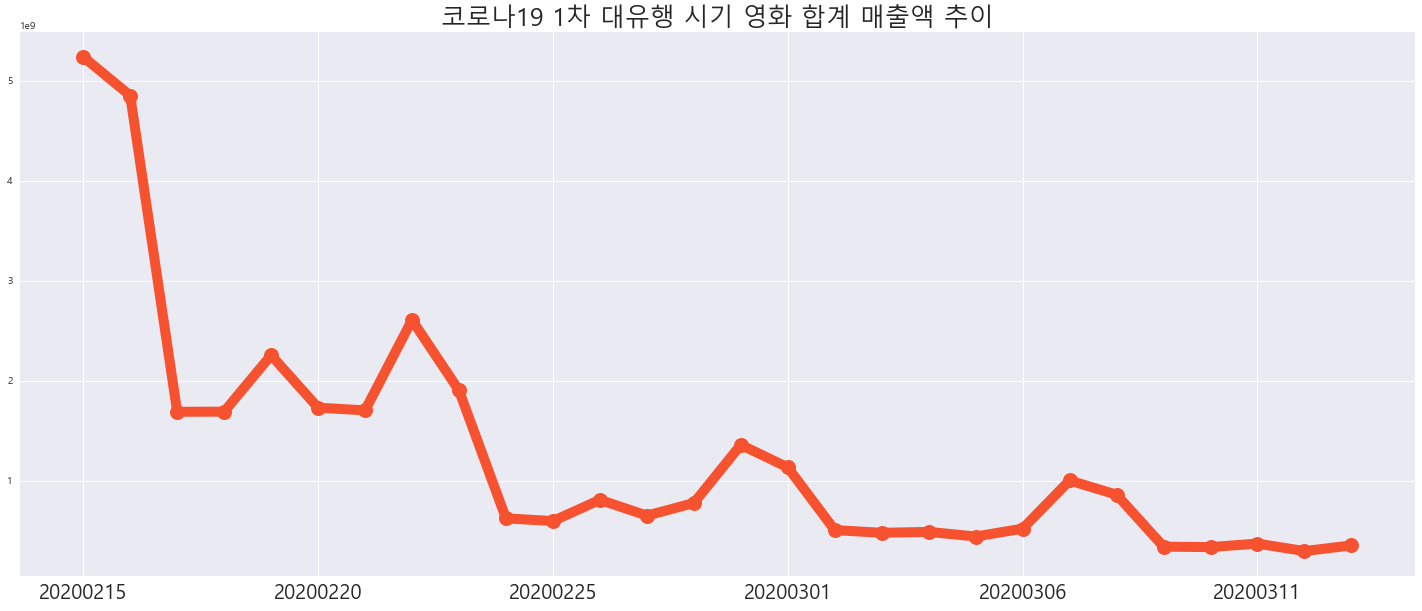

In [9]:
plt.figure(figsize = (25, 10))
feb2020['Sum'].plot(color="#F7522F", linewidth=10, marker='o', markersize=15)
plt.title("코로나19 1차 대유행 시기 영화 합계 매출액 추이", fontsize=25)
plt.tick_params(axis='x', labelsize=20)

→ __2020년 2월 29일(코로나19 신규 확진자가 909명으로 최고치 기록한 날)__부터 2주간의 총 __매출액 하락률은 약 68.74%__ 였다. 따라서 2월 29일 이후 영화 매출액은 확연히 감소했다고 할 수 있다.  

    2월 15일 ~ 2월 28일 (총 14일간) : 합계 매출액 27,123,650,200원 

    2월 29일 ~ 3월 13일 (총 14일간) : 합계 매출액 8,479,848,940원   
    
이러한 매출 하락률이 평년에 비해 얼마나 큰 편인지를 알아보기 위해 __2019년 데이터를 가져와 비교__해볼 것이다. 현재로서는 2월 말부터 영화 매출액이 급감한 이유가 코로나 때문인 것으로 보이기는 하나, 개학 및 개강으로 인한 것일 수도 있기 때문에 이를 평년과 비교해 검증해보아야 한다. 

#### 2019년 2월 14일 ~ 3월 13일 데이터 불러오기

In [10]:
feb2019 = create_a_kobis_df(14, 20190228) # 2019년도에는 2월 29일이 존재하지 않아서 28일로 대체함

feb2019

,1919 유관순,그린 북,극장판 헬로카봇: 옴파로스 섬의 비밀,극한직업,기묘한 가족,더 와이프,더 페이버릿: 여왕의 여자,돈,드래곤 길들이기 3,드래곤볼 슈퍼: 브로리,리노,메리 포핀스 리턴즈,명탐정 코난:전율의 악보,브라더 오브 더 이어,빠삐용,뺑반,사바하,슈퍼미니 2,신데렐라:마법 반지의 비밀,신밧드와 마법 양탄자,악질경찰,알리타: 배틀 엔젤,"어쩌다, 결혼",우상,이스케이프 룸,자전차왕 엄복동,증인,질투의 역사,칠곡 가시나들,캡틴 마블,콜드 체이싱,킹 오브 프리즘 -샤이니 세븐 스타즈-,페이트 스테이 나이트 헤븐즈필 제2장 로스트 버터플라이,항거:유관순 이야기,해리포터와 비밀의 방,해피 데스데이 2 유,Sum
20190214,0,0,0,1321606500,284360000,0,0,0,91768750,60484890,0,213897590,199918600,0,0,40672100,0,0,0,0,0,372091650,0,0,0,0,669567010,0,0,0,0,0,0,0,0,572932790,3827299880
20190215,0,0,0,1639898261,251100141,0,0,0,104433890,40708190,0,183943990,98198600,0,0,0,0,0,0,28177400,0,456649039,0,0,0,0,833499448,0,0,0,0,0,0,0,0,495868050,4132477009
20190216,0,0,68805630,3470459023,418279954,0,0,0,282893190,71706800,0,363502980,179275500,0,0,0,0,0,0,0,0,1035322746,0,0,0,0,1778792893,0,0,0,0,0,0,0,0,741776750,8410815466
20190217,0,0,82260200,2982662800,361419800,0,0,0,313014200,61972900,0,309145180,161075300,0,0,0,0,0,0,0,0,913111980,0,0,0,0,1916911640,0,0,0,0,0,0,0,0,614721400,7716295400
20190218,0,0,0,904081680,109315070,0,0,0,85008070,21860950,0,104654120,39602400,0,0,0,0,0,0,13963500,0,270683640,0,0,0,0,740659570,0,0,0,0,0,0,0,0,237124060,2526953060
20190219,0,0,0,902272650,121602600,0,0,0,91194700,0,0,107584630,34984400,0,0,0,34745100,0,0,0,0,279876740,0,0,0,0,808166340,0,0,0,0,0,0,0,38208000,204977840,2623613000
20190220,0,0,0,720005250,0,0,0,0,51051940,0,0,58319400,0,0,0,0,1438049010,0,98781860,0,0,118704780,0,0,0,0,623382450,0,0,0,153887290,0,0,0,120858500,89264990,3472305470
20190221,0,0,0,649660250,0,0,0,0,50169820,0,0,51693950,0,0,0,0,1165412830,0,104209770,0,0,107176780,0,0,0,0,599461310,0,0,0,101522620,0,0,0,106441000,68868120,3004616450
20190222,0,0,0,804511810,0,0,0,0,62329440,0,0,50444330,0,0,0,0,1540198127,0,137621290,0,0,141726778,0,0,0,0,754247650,0,0,0,101628702,0,0,0,127519000,73023009,3793250136
20190223,0,0,0,1722151350,0,0,0,0,134891530,0,0,93472770,0,0,0,0,3045293226,0,312750200,0,0,308884175,0,0,0,0,1578803550,0,0,0,151641195,0,0,0,160158500,94716311,7602762807


In [11]:
print("4주간 상영된 영화는 총", len(feb2019.columns) - 1, "편")

4주간 상영된 영화는 총 36 편


#### 2019년과 2020년 매출액 비교

In [12]:
feb2019sum = feb2019['Sum'].sum()
feb2020sum = feb2020['Sum'].sum()

print("2019년 매출액 :", feb2019sum)
print("2020년 매출액 :", feb2020sum)

print("19년 대비 20년 매출액 변화 :", (feb2020sum - feb2019sum) / feb2019sum * 100, "%")

2019년 매출액 : 123235328883.0
2020년 매출액 : 35603499140.0
19년 대비 20년 매출액 변화 : -71.10934059030907 %


#### 2019년 2월 15일 ~ 3월 13일 합계 매출액 추이

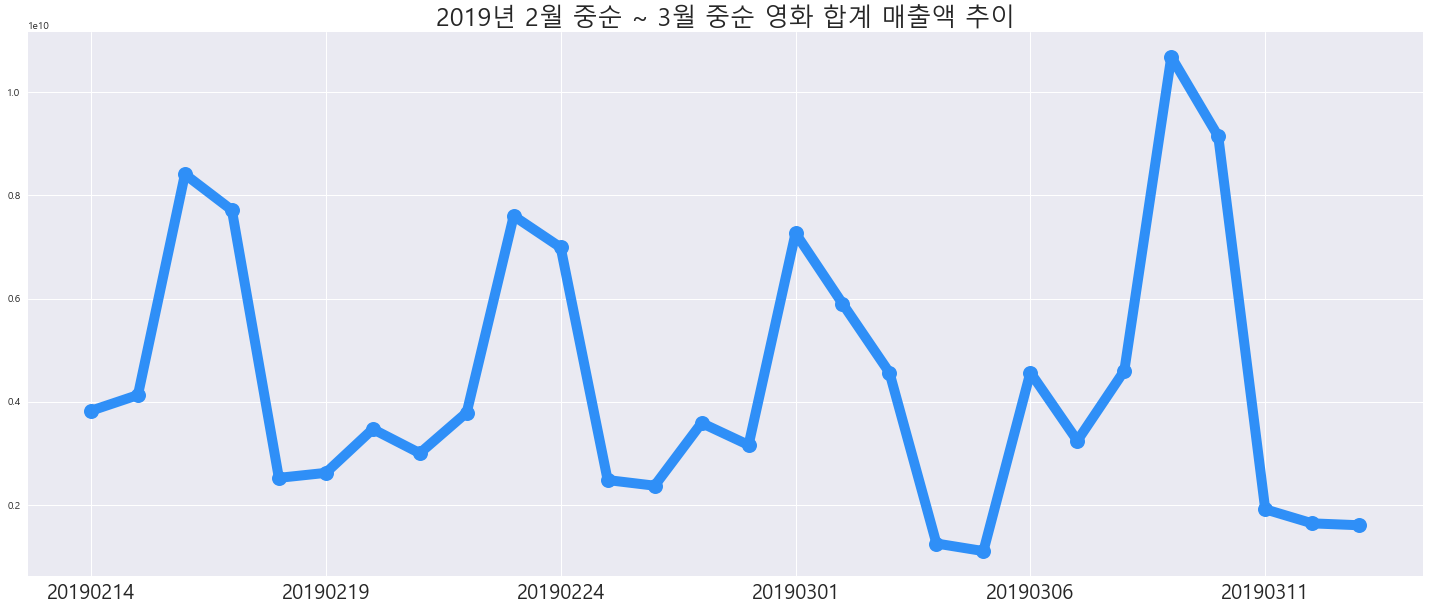

In [13]:
plt.figure(figsize = (25, 10))
feb2019['Sum'].plot(color="#2F8FF7", linewidth=10, marker='o', markersize=15)
plt.title("2019년 2월 중순 ~ 3월 중순 영화 합계 매출액 추이", fontsize=25)
plt.tick_params(axis='x', labelsize=20)

→ __2019년 2월 28일 이후 2주간의 총 매출액 하락률은 약 2.99%__였다. 따라서 평년에는 2월 말 전후로 영화 매출액에 큰 변화가 없음을 확인했다. 

    2월 14일 ~ 2월 27일 (총 14일간) : 합계 매출액 62,551,244,398원 

    2월 28일 ~ 3월 13일 (총 14일간) : 합계 매출액 60,684,084,485원   
    
2019년 그래프를 보면 일주일간의 영화 매출액 변화가 한눈에 들어온다. 우선 __주중과 주말의 매출액 차이__가 확연히 드러난다. 주중보다 주말에 매출액이 훨씬 높고, 항상 일요일보다는 토요일에 매출액이 좀 더 높다. 평일에는 __수요일과 금요일__이 가장 큰 매출액을 보이는 경향이 있다 (공휴일인 삼일절 제외). 

__"캡틴 마블"이 3월 6일 개봉__하면서 이후 며칠간 __매출액이 눈에 띄게 상승__했던 지점이 있다. 2019년 3월 개봉작 중 개봉일에 가장 많은 관객수를 모은 작품이 바로 이 영화였는데, 개봉일 자정에는 "캡틴 마블"의 예매율이 90%에 육박하기도 했다고 한다. 따라서 2020년 3월 영화 매출액 데이터와 비교할 때에는 이 점을 감안해야 할 것이다.  

보다 객관적인 결론을 위해 최근 3개년(2017, 2018, 2019) 데이터를 함께 비교해보자.

#### 같은 방법으로 2017년과 2018년 데이터 불러오기

In [14]:
feb2017 = create_a_kobis_df(14, 20170228)
feb2018 = create_a_kobis_df(14, 20180228) 

feb2017sum = feb2017['Sum'].sum()
feb2018sum = feb2018['Sum'].sum()

#### 2017 ~ 2020년 합계 매출액 추이 비교 

2017년 매출액 : 102671651809.0
2018년 매출액 : 122282071632.0
2019년 매출액 : 123235328883.0
2020년 매출액 : 35603499140.0


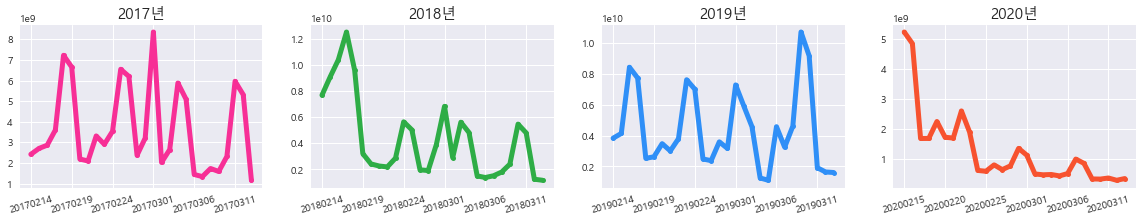

In [15]:
plt.figure(figsize=(20, 3))

plt.subplot(141)
feb2017['Sum'].plot(color="#F72F96", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2017년", fontsize=15)

plt.subplot(142)
feb2018['Sum'].plot(color="#2EAD46", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2018년", fontsize=15)

plt.subplot(143)
feb2019['Sum'].plot(color="#2F8FF7", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2019년", fontsize=15)

plt.subplot(144)
feb2020['Sum'].plot(color="#F7522F", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2020년", fontsize=15)

print("2017년 매출액 :", feb2017sum)
print("2018년 매출액 :", feb2018sum)
print("2019년 매출액 :", feb2019sum)
print("2020년 매출액 :", feb2020sum)

→ __2017년, 2018년, 2019년은 모두 2월 28일 전후로 매출액에 큰 차이가 없음__을 확인할 수 있다. 반면, __2020년도에는 시간이 경과할수록 매출액이 하락세__를 띠는 것을 알 수 있다. 

또 하나 중요하게 살펴볼 부분은 __2020년의 가장 큰 매출액 하락이 2월 29일에 발생하지 않았다__는 점이다. 신규 확진자 수가 최고치를 기록한 직후에 영화 매출액이 가장 크게 급감했을 것이라는 가설과 다른 결과이다. __코로나로 인한 매출 하락이 언제부터 시작되었으며, 가장 급감한 구간은 언제인지__ 알아볼 필요가 있어 보인다. 이를 위해서 __좀 더 장기적인 기간__동안의 매출액 데이터를 살펴보고자 한다. 국내 첫 코로나19 환자 발생일이 2020년 1월 20일인 점을 감안해 같은 해 1월 중순부터 3월 중순까지의 매출액 데이터를 들고온다.

#### 2020년 1월 16일 ~ 3월 15일 데이터 불러오기

In [16]:
feb2020_longterm = create_a_kobis_df(30, 20200215)

feb2020_longterm

,1917,걸즈 앤 판처 최종장,겨울왕국 2,그링고,극장판 미니특공대: 공룡왕 디노,극장판 원피스 스탬피드,기생충,나쁜 녀석들: 포에버,나이브스 아웃,나이트 헌터,남산의 부장들,다크 워터스,닥터 두리틀,더 보이 2: 돌아온 브람스,메멘토,미드웨이,미스터 주: 사라진 VIP,백두산,버즈 오브 프레이(할리 퀸의 황홀한 해방),숀더쉽 더 무비: 꼬마 외계인 룰라!,수퍼 소닉,스타 이즈 본,스타워즈: 라이즈 오브 스카이워커,스파이 지니어스,시동,시원찮은 그녀를 위한 육성방법 피날레,신의 한 수: 귀수편,아내를 죽였다,어바웃 타임,엠마,오즈의 마법사: 요술구두와 말하는 책,울프 콜,이 멋진 세계에 축복을! 붉은 전설,인비저블맨,인셉션,작은 아씨들,장마,정직한 후보,젠틀맨,조조 래빗,지푸라기라도 잡고 싶은 짐승들,천문: 하늘에 묻는다,클로젯,타오르는 여인의 초상,페인 앤 글로리,프린스 코기,핑크퐁 시네마 콘서트 : 우주대탐험,"하이, 젝시",하이큐!! 땅 VS 하늘,해리포터와 아즈카반의 죄수,해치지않아,히트맨,Sum
20200116,0,0,0,0,0,0,0,422873150,0,0,0,0,349393740,0,0,36293200,0,150656960,0,0,0,0,68388620,0,38398620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53462180,0,49006120,0,0,0,0,0,0,746989720,40894000,1956356310
20200117,0,0,27377440,0,0,0,0,548876940,0,0,0,0,427338960,0,0,41715140,0,169453780,0,0,0,0,93320340,0,35432720,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62644680,0,49174720,0,0,0,0,0,0,920524920,0,2375859640
20200118,0,0,61910160,0,0,0,0,1152804950,0,0,0,0,1008454220,0,0,78644960,0,361291560,0,0,0,0,191313400,0,66468820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,124903720,0,73594520,0,0,0,0,0,0,2138136630,0,5257522940
20200119,0,0,57797460,0,0,0,0,1000154610,0,0,0,0,873568490,0,0,67608980,0,326328200,0,0,0,0,163201040,0,56235620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,115225400,0,82748980,0,0,0,0,0,0,1927802340,0,4670671120
20200120,0,0,0,0,0,0,0,298071730,0,0,14615000,0,229108990,0,0,0,0,110874680,0,0,0,0,39503100,0,23407040,0,0,27006000,0,0,0,0,0,0,0,0,0,0,0,0,0,45493600,0,49364460,0,0,0,0,0,0,541749240,0,1379193840
20200121,0,0,25480840,0,0,0,0,274633780,0,0,0,0,225414900,0,0,24920420,0,103232860,0,0,0,0,48973220,0,24186580,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46325700,0,54057260,0,0,0,0,0,0,509942200,0,1337167760
20200122,0,0,0,0,0,0,0,48589700,0,0,2048853040,0,67128840,0,0,0,344166220,0,0,0,0,0,0,163129000,0,0,0,0,0,0,15913920,0,0,0,0,0,0,0,0,0,0,0,0,39325720,0,16419000,0,0,0,0,182702700,636472740,3562700880
20200123,0,0,0,0,0,0,0,75633780,0,0,2774779700,0,80653380,0,0,0,401875440,17562520,0,0,0,0,0,211854560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43863200,0,0,0,0,55729140,0,231316090,994961160,4888228970
20200124,0,0,0,0,0,0,0,85619360,0,0,4872825430,0,132182060,0,0,0,710463490,28677400,0,0,0,0,0,441810160,0,0,0,0,0,0,33966740,0,0,0,0,0,0,0,0,0,0,0,0,53464820,0,0,0,0,0,0,364797440,2010133250,8733940150
20200125,0,0,0,0,0,0,0,91157940,0,0,6413286040,0,124304520,0,0,0,918868640,38872120,0,0,0,0,0,436820080,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19061960,0,38104760,0,0,0,0,0,0,391169100,3003851810,11475496970


#### 2020년 1월 16일 ~ 3월 15일 합계 매출액 추이

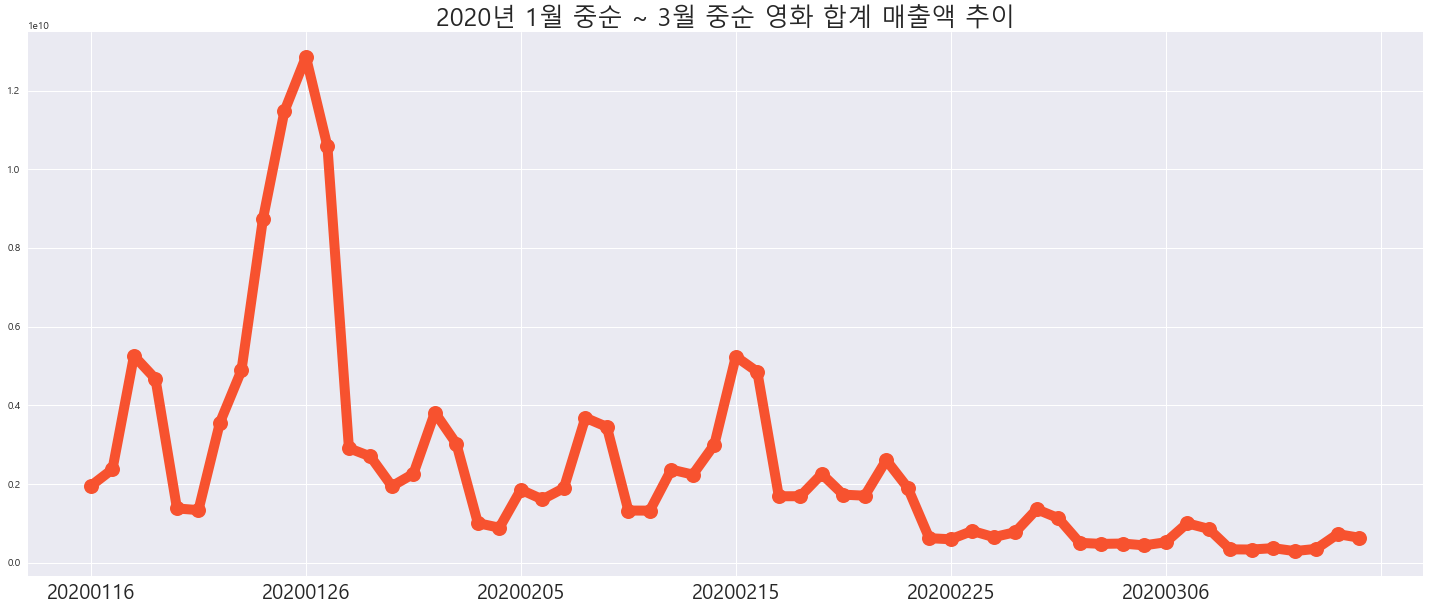

In [17]:
plt.figure(figsize=(25, 10))
feb2020_longterm['Sum'].plot(color="#F7522F", linewidth=10, marker='o', markersize=15)
plt.title("2020년 1월 중순 ~ 3월 중순 영화 합계 매출액 추이", fontsize=25)
plt.tick_params(axis='x', labelsize=20)

※ __2020년 1월 24일 ~ 27일은 설연휴__였기 때문에 평소에 비해 매출액이 대폭 증가할 수 밖에 없던 특수한 시기임을 감안해야 한다. 

전체적인 패턴을 잘 살펴보면 __2월 중순 이후부터는 매출액이 감소하고 이전과 다소 다른 패턴__의 그래프가 나타남을 알 수 있다. 2월 21일은 금요일임에도 불구하고 상당히 낮은 매출을 기록하며, 오히려 목요일보다 매출이 하락했음이 확인되었다. 뒤이어 22일과 23일 주말도 이전의 주말들에 비해서 훨씬 적은 매출을 기록했다. 이어지는 24일 월요일부터는 매출액이 최저를 기록하며, 하락한 매출액이 3월까지 이어지는 것을 발견할 수 있다.   

그렇다면 __코로나로 인한 매출액 하락은 2월 21일 즈음 시작__되었으며, __매출이 처음 급감한 구간은 21일과 24일 사이__라고 볼 수 있다. 신규 확진자 수가 최고치를 찍었던 2월 29일 직후에는 생각보다 큰 매출 급감이 없었던 것으로 확인되었다. 그렇다면 2월 21일에는 어떤 일이 있었기에 매출액이 감소하기 시작했을까? 알아본 결과, 2월 20일에는 우리나라에서 하루 사이에 확진자가 50명 가량 늘었다고 한다. 또한, 첫 번째 사망자가 발생한 날이기도 하다 (출처: 위키백과). 20일 언론에 코로나19 관련 보도가 집중적으로 이루어지고 나서 그 다음 날인 21일부터 영화 매출이 하락하기 시작했다고 해석할 수 있다. 

추가적으로 코로나19 1차 대유행 시기에는 어떤 영화들이 개봉했는지, 어떤 장르가 흥행했는지 등이 궁금해져서 분석을 해보게 되었다.   

#### 2020년 2월 15일 ~ 3월 13일 영화별 매출액

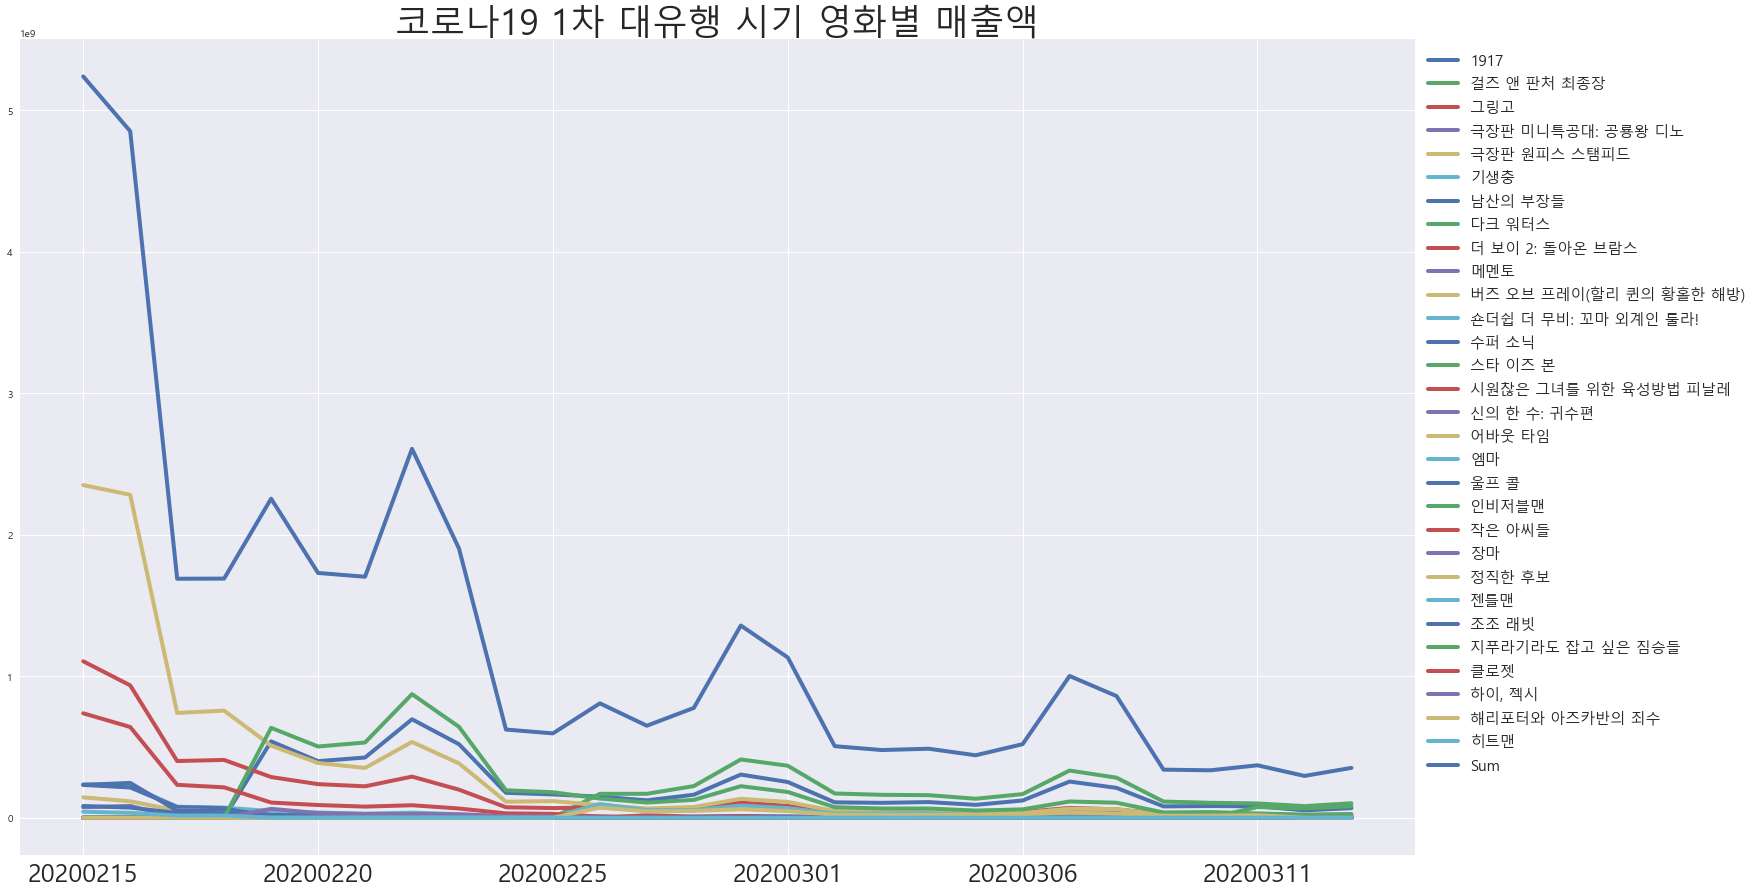

In [18]:
plt.rcParams["figure.figsize"] = (25, 15)
feb2020.plot(linewidth=4)
plt.title("코로나19 1차 대유행 시기 영화별 매출액", fontsize=35)
plt.tick_params(axis='x', labelsize=25)
plt.legend(bbox_to_anchor=(1, 1), fontsize=15)

가장 위에 나타난 파랑색 그래프는 Sum, 즉 총 매출액을 나타내는 선이다. 영화 종류가 워낙 많고 매출액 추이가 비슷해서 그래프가 잘 보이지 않는다. 매출액이 0에서 1,500,000,000원인 구간을 확대해서 다시 시각화해본다.

(0, 1500000000)

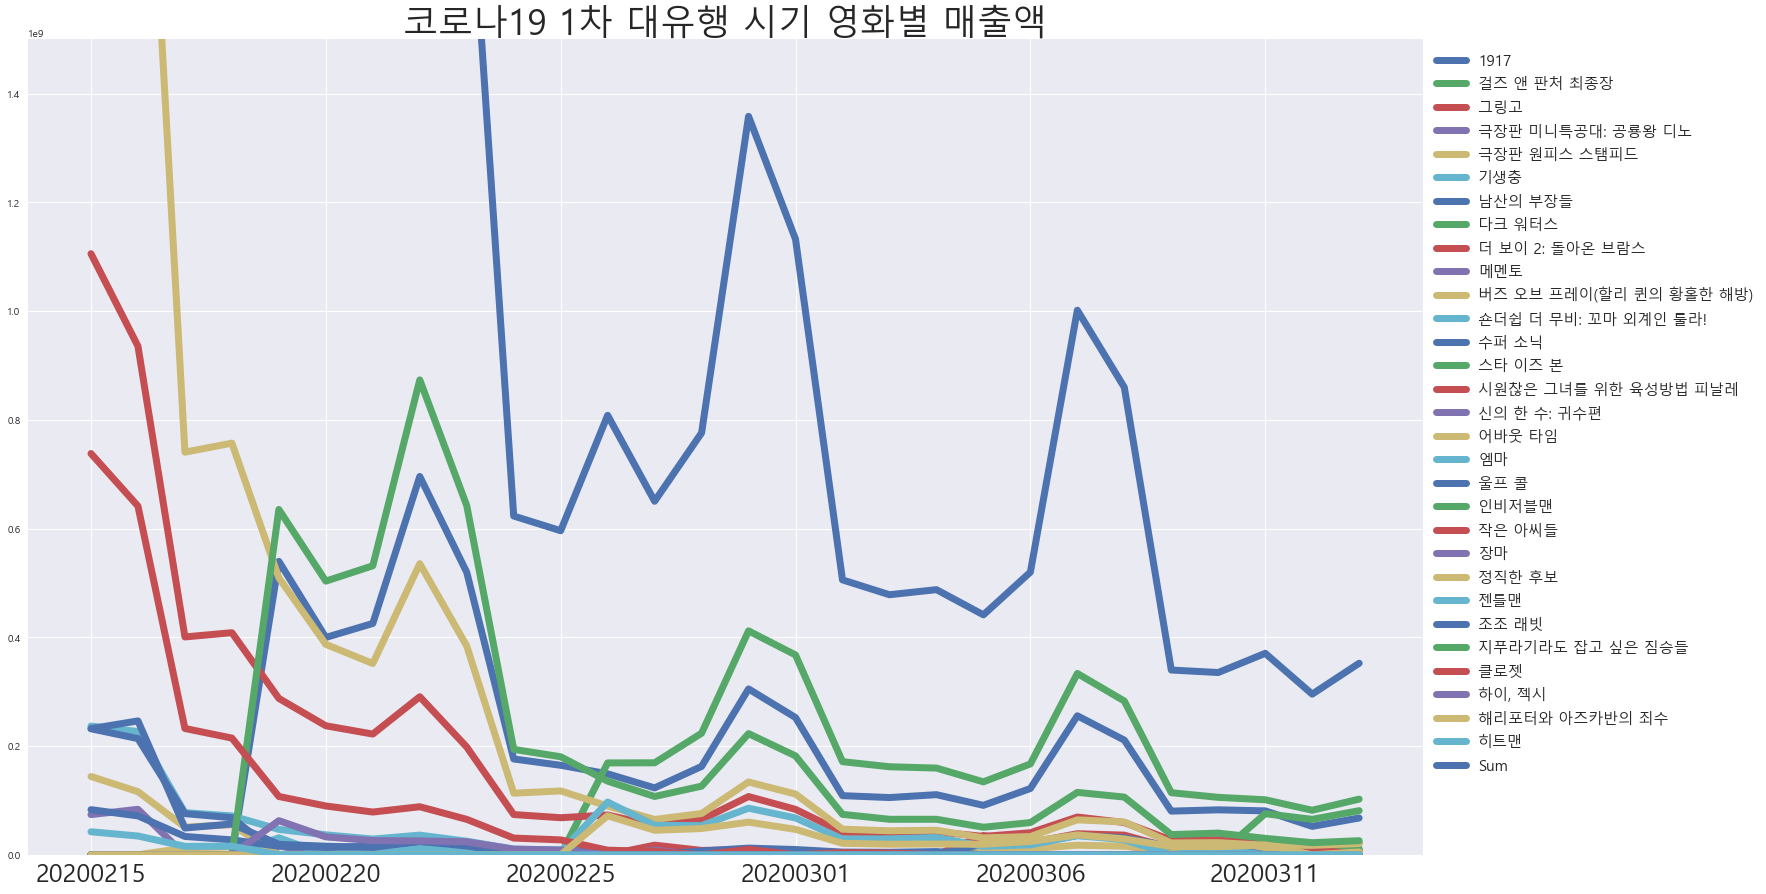

In [19]:
plt.rcParams["figure.figsize"] = (25, 15)
feb2020.plot(linewidth=7)
plt.title("코로나19 1차 대유행 시기 영화별 매출액", fontsize=35)
plt.tick_params(axis='x', labelsize=25)
plt.legend(bbox_to_anchor=(1, 1), fontsize=15)
plt.ylim([0, 1500000000]) 

→ 2020년 2월 15일부터 3월 13일까지 __상영된 영화는 총 30편__으로, 2019년의 36편과 비교하면 더 적은 편수이다. 이 중 __재개봉 영화는 총 5편__이다 ("기생충", "메멘토", "스타 이즈 본", "어바웃 타임", "해리포터와 아즈카반의 죄수"). 

__2월 25일 이후 꾸준히 매출액 1 ~ 3위를 기록한 영화는 "인비저블맨", "1917", 지푸라기라도 잡고싶은 짐승들"__이었다. "정직한 후보", "작은 아씨들", "클로젯"은 2월 19일 이전까지 매출액 1 ~ 3위를 지키다가 새로운 영화들이 개봉하면서 자리를 내어주게 되었다.  

이 중 __저예산 공포영화 "인비저블맨"의 흥행__에 주목할 필요가 있어 보인다. 공포영화는 일반적으로 여름에 흥행한다는 상식을 깨고 2월과 3월에 이 영화가 매출액 1위를 기록한 것이다. 이는 코로나로 인해 느끼는 공포심과 긴장을 공포영화로 해소하여 카타르시스를 추구하고자 하는 사람들의 심리가 반영된 결과라고 볼 수 있다. 

한편, __"1917"는 코로나19의 타격을 크게 입은 작품__이었다. 각종 시상식에서 수상을 하며 언론에서 수많은 극찬이 쏟아진 작품임에도 불구하고 개봉 후 크게 흥행하지 못했기 때문이다. (이후 2020년 4월에 박스오피스 1위를 기록하며 역주행에 성공하지만 2월 ~ 3월 시점에서는 흥행에서 부진했음) 

~~각 영화별로 표준화를 실시하려고 했으나, 무슨 이유에서인지 제대로 되지 않아서 그래프를 그려보면 뒤죽박죽이 되었다. ~~

--------

#### (2) 코로나 2차 대유행 시기 - 2020.08.27. 기점으로 전후 14일 비교

#### 2020년 8월 13일 ~ 9월 9일 데이터 불러오기

In [20]:
aug2020 = create_a_kobis_df(14, 20200827)

aug2020

,#살아있다,강철비2: 정상회담,결백,고스트 오브 워,극장판 시로바코,극장판 짱구는 못말려: 신혼여행 허리케인~ 사라진 아빠!,기기괴괴 성형수,나의 소녀시대,남매의 여름밤,다만 악에서 구하소서,더 프린세스 : 도둑맞은 공주,드라이브,메멘토,반교: 디텐션,반도,밤쉘: 세상을 바꾼 폭탄선언,브링 더 소울 : 더 무비,비바리움,사랑이 눈뜰 때,시크릿 가든,아메리칸 잡,아무도 없다,알라딘,애니멀 크래커,에이바,엘라 벨라 빙고: 친구 찾기 대작전,오! 문희,오케이 마담,워터 릴리스,인셉션,작은 소망,카일라스 가는 길,테넷,하워즈 엔드,후쿠오카,Sum
20200813,0,104057940,0,0,0,0,0,0,0,1157994580,33493380,0,0,21061000,61706920,0,0,0,0,0,0,0,0,22335360,0,0,0,722343760,14130700,52494490,14299000,0,0,0,0,2203917130
20200814,0,172526890,0,0,0,0,0,0,0,2024411500,56793540,0,0,33123440,110511090,0,0,12048000,0,0,0,0,0,38887180,0,0,0,1318394280,14955172,66546840,0,0,0,0,0,3848197932
20200815,0,289252250,0,0,0,0,0,0,0,3136208050,111404260,0,0,41686510,147390380,0,0,0,0,0,0,0,12219200,74670690,0,0,0,2150664580,14269300,79777050,0,0,0,0,0,6057542270
20200816,0,272987360,0,0,0,0,0,0,0,2843052760,85793320,0,0,42792860,136214110,0,0,14481000,0,0,0,0,10889980,58232480,0,0,0,1955143960,0,71923980,0,0,0,0,0,5491511810
20200817,0,184005550,0,0,0,0,0,0,0,1765663700,91490800,0,0,31282480,85117790,0,0,0,0,0,0,0,0,57191160,0,10168400,0,1254896250,11537600,55413660,0,0,0,0,0,3546767390
20200818,0,56437510,0,0,0,0,0,0,0,625477730,13203460,0,0,14172130,31605200,0,0,0,0,0,0,0,4301000,7420200,0,0,0,362073840,4528480,24631280,0,0,0,0,0,1143850830
20200819,0,45503010,0,0,0,0,0,17807400,0,533789010,6803780,0,36221500,13061950,23041700,0,0,0,0,15294260,0,0,0,0,0,0,0,316197640,0,13770680,0,0,0,0,0,1021490930
20200820,0,31310600,0,0,9357720,97999560,0,11904100,17765870,414113280,0,0,16344500,0,15594040,0,0,0,0,11544060,0,0,0,0,0,0,0,242498400,0,0,0,0,0,0,0,868432130
20200821,0,30290910,0,0,0,82397820,0,10516700,11063780,451533680,0,0,19178500,11743420,17449870,0,0,0,0,13716080,0,0,0,0,0,0,0,260371370,0,0,0,0,0,0,0,908262130
20200822,0,38301160,0,0,0,173277620,0,0,10405680,648927360,0,0,15657000,17273800,19006750,0,0,0,0,14847860,0,0,0,0,0,0,0,377546980,0,0,0,0,438675920,0,0,1753920130


In [21]:
print("4주간 상영된 영화는 총", len(aug2020.columns) - 1, "편")

4주간 상영된 영화는 총 35 편


#### 2020년 8월 13일 ~ 9월 9일 합계 매출액 추이

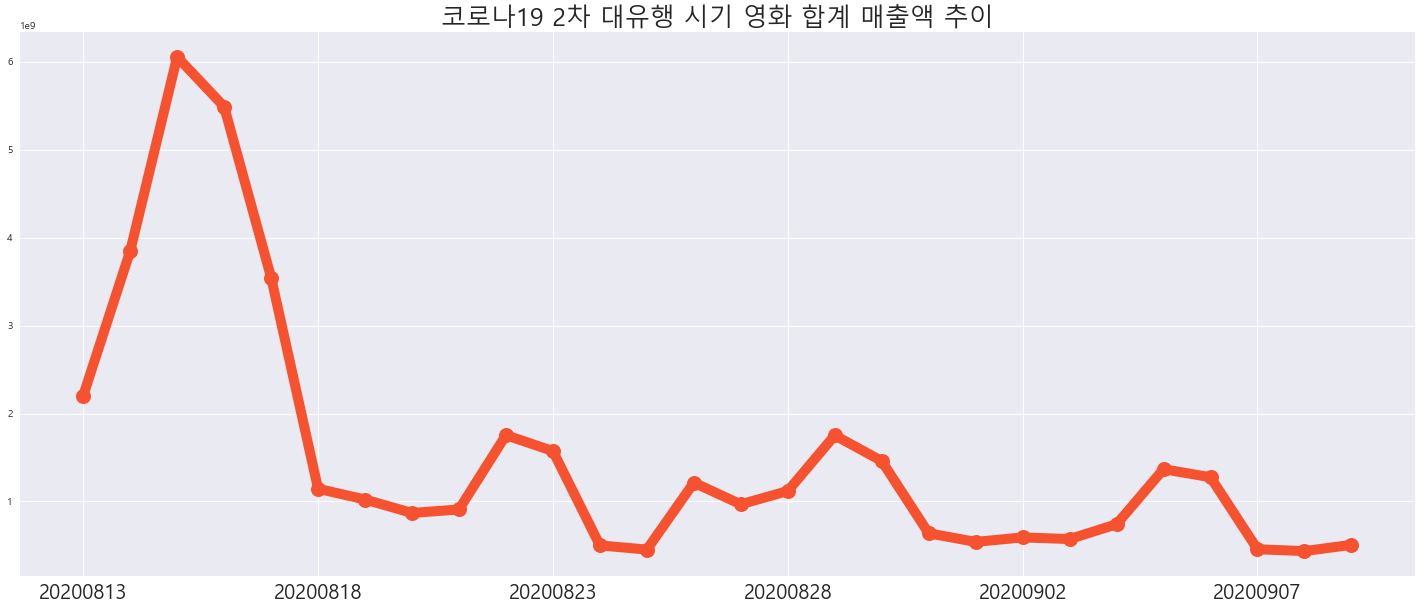

In [22]:
plt.figure(figsize = (25, 10))
aug2020['Sum'].plot(color="#F7522F", linewidth=10, marker='o', markersize=15)
plt.title("코로나19 2차 대유행 시기 영화 합계 매출액 추이", fontsize=25)
plt.tick_params(axis='x', labelsize=20)

→ __2020년 8월 27일(코로나19 신규 확진자가 441명으로 최고치 기록한 날)__부터 2주간의 총 __매출액 하락률은 약 59.42%__ 였다 (코로나19 1차 대유행 시기의 경우, 매출액 하락률은 68.74%였음). 따라서 8월 27일 이후 영화 매출액은 확연히 감소했음을 확인했으나, __공휴일인 8월 15일__은 매출액이 높을 수 밖에 없는 특수한 상황이었던 점을 고려해야한다. 

    8월 13일 ~ 8월 26일 (총 14일간) : 합계 매출액 30,581,225,392원 

    8월 27일 ~ 9월 9일 (총 14일간) : 합계 매출액 12,411,383,960원   
    
앞서 코로나19 1차 대유행 시기 데이터에서 분석했듯, 이러한 매출 하락률이 평년에 비해 얼마나 큰 편인지 알아보기 위해 __2019년 데이터를 가져와 비교__해본다. 

#### 2019년 8월 13일 ~ 9월 9일 데이터 불러오기

In [23]:
aug2019 = create_a_kobis_df(14, 20190827) 

aug2019

,47미터 2,광대들: 풍문조작단,그것: 두 번째 이야기,극장판 헬로카봇 : 달나라를 구해줘!,김복동,나쁜 녀석들: 더 무비,라이온 킹,레드슈즈,마이펫의 이중생활 2,벌새,변신,봉오동 전투,분노의 질주: 홉스&쇼,브링 더 소울 : 더 무비,사자,안나,안녕 베일리,"안녕, 티라노: 영원히, 함께",알라딘,암전,애프터,앵그리 버드 2: 독수리 왕국의 침공,엑시트,우리집,원더랜드,유열의 음악앨범,커런트 워,타짜: 원 아이드 잭,"힘을 내요, 미스터 리",Sum
20190813,0,0,0,0,0,0,82597380,77033980,151466400,0,56892000,1625462500,0,107258290,132159270,0,0,0,132032820,0,0,75418280,1578158420,0,0,0,0,0,0,4018479340
20190814,0,0,0,0,47530120,0,0,37114200,84478170,0,0,1719469180,2935002750,0,51203820,0,0,103907360,39114030,0,0,0,1623147660,0,63374970,0,0,0,0,6704342260
20190815,0,0,0,0,0,0,0,125757830,234595360,0,0,4160776610,4978289610,0,112294200,0,0,453103620,0,271626360,0,79458320,3401752680,0,226088880,0,0,0,0,14043743470
20190816,0,0,0,0,0,0,0,47601150,95473460,0,0,1778793687,2572150167,0,60897200,0,0,92805260,35621690,143775913,0,0,1752178510,0,67572710,0,0,0,0,6646869747
20190817,0,0,0,0,0,0,0,88595210,147790970,0,0,2809144588,4117876568,0,67134740,0,0,221755420,57562670,169675172,0,0,2715811280,0,97147170,0,0,0,0,10492493788
20190818,0,0,0,0,0,0,0,89728820,134634210,0,0,2381109970,3621789890,0,48037960,0,0,210056760,52996300,136185230,0,0,2277728650,0,85775130,0,0,0,0,9038042920
20190819,0,0,0,0,0,0,0,24577120,39812500,0,0,754699120,1185622290,0,19342140,0,0,47705140,23798620,62716580,0,0,805831910,0,30392360,0,0,0,0,2994497780
20190820,0,0,0,0,16374360,0,0,28479420,56509350,0,0,692321950,996607040,0,0,0,0,49364860,23674180,54152100,0,0,765727160,0,40214010,0,0,0,0,2723424430
20190821,0,662099850,0,0,0,0,0,15279480,27985080,0,817343910,524479340,808148030,0,0,0,0,30961740,14641440,0,0,0,659824370,0,15405300,0,0,0,0,3576168540
20190822,0,484228840,0,0,0,0,0,15678580,21398620,0,720853810,449595710,716926020,0,0,0,0,22250480,0,0,72456620,0,574269200,0,0,0,295118800,0,0,3372776680


In [24]:
print("4주간 상영된 영화는 총", len(aug2019.columns) - 1, "편")

4주간 상영된 영화는 총 29 편


#### 2019년과 2020년 매출액 비교

In [25]:
aug2019sum = aug2019['Sum'].sum()
aug2020sum = aug2020['Sum'].sum()

print("2019년 매출액 :", aug2019sum)
print("2020년 매출액 :", aug2020sum)

print("19년 대비 20년 매출액 변화 :", (aug2020sum - aug2019sum) / aug2019sum * 100, "%")

2019년 매출액 : 129525724752.0
2020년 매출액 : 42992591352.0
19년 대비 20년 매출액 변화 : -66.80768130476247 %


→ 앞서 살펴본 2월 ~ 3월 데이터에서는 19년 대비 20년 매출액이 -71.11%

#### 2019년 2월 15일 ~ 3월 13일 합계 매출액 추이

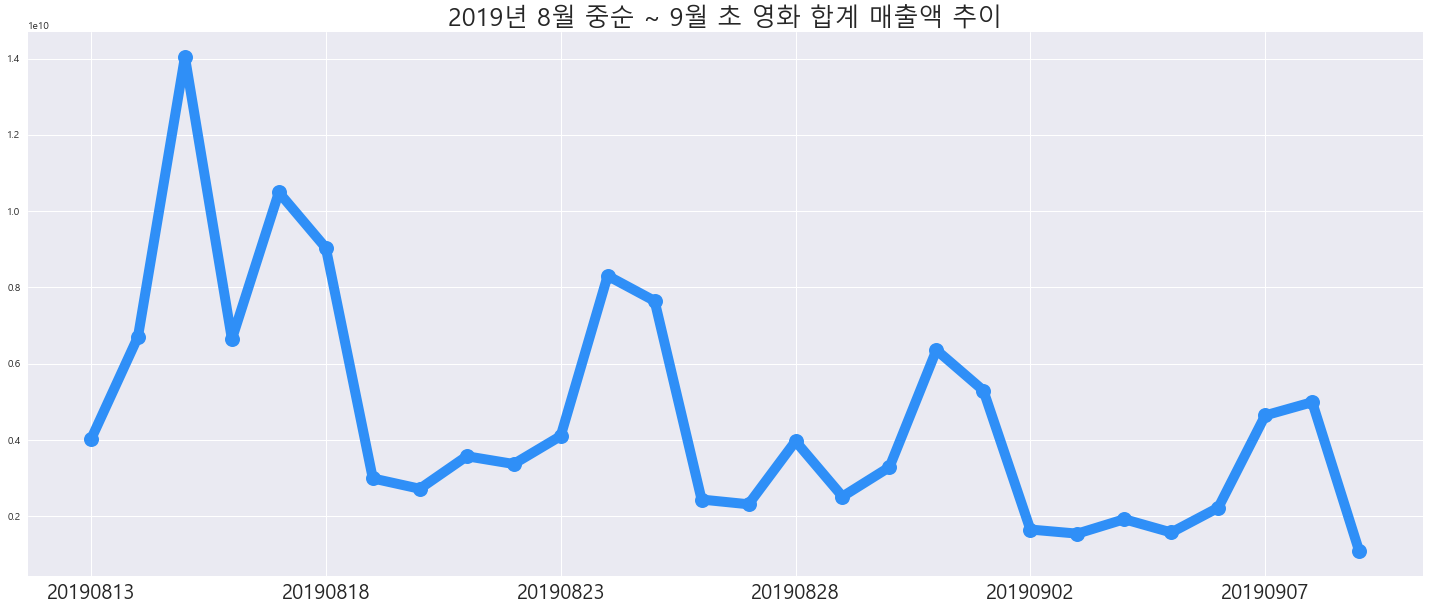

In [26]:
plt.figure(figsize = (25, 10))
aug2019['Sum'].plot(color="#2F8FF7", linewidth=10, marker='o', markersize=15)
plt.title("2019년 8월 중순 ~ 9월 초 영화 합계 매출액 추이", fontsize=25)
plt.tick_params(axis='x', labelsize=20)

→ __2019년 8월 27일 이후 2주간의 총 매출액 하락률은 약 49.58%__였다. 2020년의 하락률인 59.42%라는 수치와 비교했을 때 더 작은 숫자이긴 하지만 1차 대유행 시기(2020년: 68.74%, 2019년: 2.99%)에서처럼 큰 차이가 난다고 보기는 힘들다.  

    8월 13일 ~ 8월 26일 (총 14일간) : 합계 매출액 86,109,848,013원 

    8월 27일 ~ 9월 9일 (총 14일간) : 합계 매출액 43,415,876,739원   
    
그래프를 보면 시간이 경과할수록 매출액이 감소하는 양상을 확인할 수 있는데, 이는 __9월 초 개강 및 개학__으로 인한 결과라는 예측을 해본다.  

보다 객관적인 결론을 위해 최근 3개년(2017, 2018, 2019) 데이터를 함께 비교해보자.

#### 같은 방법으로 2017년과 2018년 데이터 불러오기

In [27]:
aug2017 = create_a_kobis_df(14, 20170827)
aug2018 = create_a_kobis_df(14, 20180827) 

aug2017sum = aug2017['Sum'].sum()
aug2018sum = aug2018['Sum'].sum()

#### 2017년 ~ 2020년 합계 매출액 추이 비교

2017년 매출액 : 153103992614.0
2018년 매출액 : 140532388593.0
2019년 매출액 : 129525724752.0
2020년 매출액 : 42992591352.0


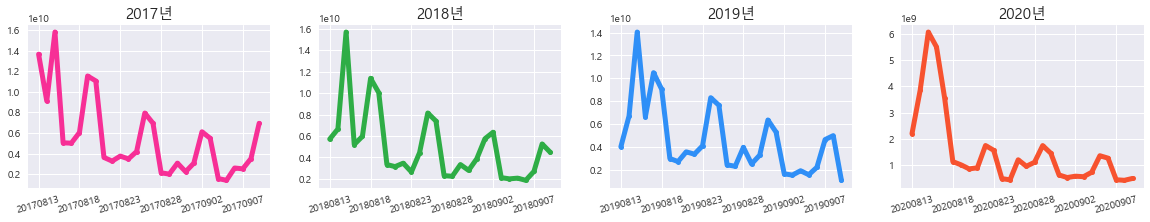

In [28]:
plt.figure(figsize=(20, 3))

plt.subplot(141)
aug2017['Sum'].plot(color="#F72F96", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2017년", fontsize=15)

plt.subplot(142)
aug2018['Sum'].plot(color="#2EAD46", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2018년", fontsize=15)

plt.subplot(143)
aug2019['Sum'].plot(color="#2F8FF7", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2019년", fontsize=15)

plt.subplot(144)
aug2020['Sum'].plot(color="#F7522F", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2020년", fontsize=15)

print("2017년 매출액 :", aug2017sum)
print("2018년 매출액 :", aug2018sum)
print("2019년 매출액 :", aug2019sum)
print("2020년 매출액 :", aug2020sum)

→ __2017년, 2018년, 2019년, 2020년 모두 광복절에 가장 높은 매출액__을 기록했고, 이후부터는 __9월 초까지 매출액이 쭉 하락__한 것을 확인했다. 이는 앞서 언급했듯 __2학기 개학 및 개강의 영향__이 컸을 것으로 파악된다. __절대적인 매출액에서 2017년 ~ 2019년과 2020년의 차이__는 매우 크다 (2020년 매출액이 저조).  

또 하나 짚고 넘어갈 부분은 __2020년의 가장 큰 매출액 하락이 8월 27일 직후에 발생했다고 단정짓기 힘들다__는 점이다. __좀 더 장기적인 기간__의 매출액 데이터를 들고와 살펴보도록 하자.

#### 2020년 7월 28일 ~ 9월 25일 데이터 불러오기

In [29]:
aug2020_longterm = create_a_kobis_df(30, 20200827)

aug2020_longterm

,#살아있다,1942: 언노운 배틀,O.J. 심슨 사건 파일,강철비2: 정상회담,검객,결백,고스트 오브 워,공포분자,공포체험라디오 4DX,극장판 시로바코,극장판 짱구는 못말려: 신혼여행 허리케인~ 사라진 아빠!,기기괴괴 성형수,기묘한 이야기: 리플레이,나의 소녀시대,남매의 여름밤,뉴 뮤턴트,다만 악에서 구하소서,더 렌탈 : 소리없는 감시자,더 프린세스 : 도둑맞은 공주,도망친 여자,돌멩이,드라이브,디바,매지컬: 공주를 웃겨라,메멘토,뮬란,미녀와 야수,반교: 디텐션,반도,밤쉘: 세상을 바꾼 폭탄선언,브레이크 더 사일런스: 더 무비,브링 더 소울 : 더 무비,블랙아웃 : 인베이젼 어스,블루 아워,비독: 파리의 황제,비바리움,빅샤크3: 젤리몬스터 대소동,사랑이 눈뜰 때,세인트 주디,소년 아메드,소년시절의 너,송 오브 러브,시네마 천국,시크릿 가든,아메리칸 잡,아무도 없다,아웃포스트,알라딘,애니멀 크래커,에이바,엘라 벨라 빙고: 친구 찾기 대작전,오! 문희,오케이 마담,온워드: 단 하루의 기적,워터 릴리스,위 섬온 더 다크니스,위대한 쇼맨,인디애니페스트2020 릴레이작가 초청전,인셉션,작은 소망,존 윅: 특별판,주식회사 스페셜액터스,죽이는 여자,죽지않는 인간들의 밤,지니어스 독,카일라스 가는 길,테넷,테스와 보낸 여름,파리의 인어,팬데믹,하워즈 엔드,후쿠오카,Sum
20200728,20062600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25092000,0,0,0,0,0,0,0,0,0,0,0,574545360,20876940,0,0,0,10500660,0,0,0,0,0,0,14444500,0,0,0,0,0,0,50940240,0,0,0,0,0,7751960,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17232000,10978020,0,0,752424280
20200729,3743200,6960360,0,1415021820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,481897780,5977180,0,0,0,0,0,0,19313900,0,0,0,9278000,0,0,0,0,0,0,55960840,0,0,0,0,0,0,0,0,0,0,0,0,7169260,0,0,0,0,0,0,0,7028000,0,0,0,2012350340
20200730,2727100,0,0,1071915220,0,0,0,0,0,0,0,0,1062000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,463391260,0,0,0,0,0,0,0,27193180,0,0,6059000,9536500,0,0,0,0,0,0,50415100,0,0,0,0,0,0,0,0,0,0,0,0,8974140,0,876000,0,0,0,0,0,0,0,0,0,1642149500
20200731,0,0,0,1392228320,0,0,0,0,0,0,0,0,0,0,0,0,18670000,0,0,0,0,0,0,0,0,0,0,0,711719700,10474240,0,0,0,0,0,0,37643760,0,8709980,0,14206500,0,0,0,0,0,0,61849040,0,0,0,0,0,8903400,0,0,0,0,0,0,11986260,0,0,0,0,0,0,0,0,0,0,0,2276391200
20200801,5425400,0,0,2426214140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1075815260,17246520,0,0,0,0,0,0,80063460,0,8509400,0,18864000,0,0,0,0,0,0,78601240,0,0,0,0,0,15101040,0,0,0,0,0,0,17899160,0,0,0,0,0,0,0,0,0,0,0,3743739620
20200802,4853500,0,0,2056361060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,889457880,8772800,0,0,0,0,0,0,84298960,0,0,8218000,18541000,0,0,0,0,0,0,69111800,0,0,0,0,0,14096160,0,0,0,0,0,0,12183160,0,0,0,0,0,0,0,0,0,0,0,3165894320
20200803,0,4550100,0,929868540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,421226760,0,0,0,0,0,0,0,62550780,0,5330100,0,12336000,0,0,0,0,0,0,44401900,0,0,0,0,8410000,8973020,0,0,0,0,0,0,8258600,0,0,0,0,0,0,0,0,0,0,0,1505905800
20200804,0,0,0,869623880,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,451245160,6979520,0,0,0,0,0,0,69932920,0,6509380,0,14731000,0,0,0,0,0,0,47529640,0,0,0,0,7200000,9564320,0,0,0,0,0,0,8512200,0,0,0,0,0,0,0,0,0,0,0,1491828020
20200805,0,0,5106000,409442000,0,0,0,0,0,0,0,0,0,0,0,0,2838086980,0,0,0,0,0,0,0,0,0,17453360,0,204397940,0,0,0,0,0,0,0,27800300,0,0,0,5738000,0,0,0,0,0,0,27125700,92464560,0,0,0,0,4639020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3632253860
20200806,0,0,0,359383840,0,0,0,0,0,0,0,0,0,0,0,0,2367497760,0,0,0,0,0,0,0,0,0,16828760,0,182040500,0,0,0,0,0,0,0,22575380,0,0,0,8623500,0,0,0,0,0,0,25913900,87752620,0,0,0,10033000,4226640,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3084875900


#### 2020년 7월 28일 ~ 9월 25일 합계 매출액 추이

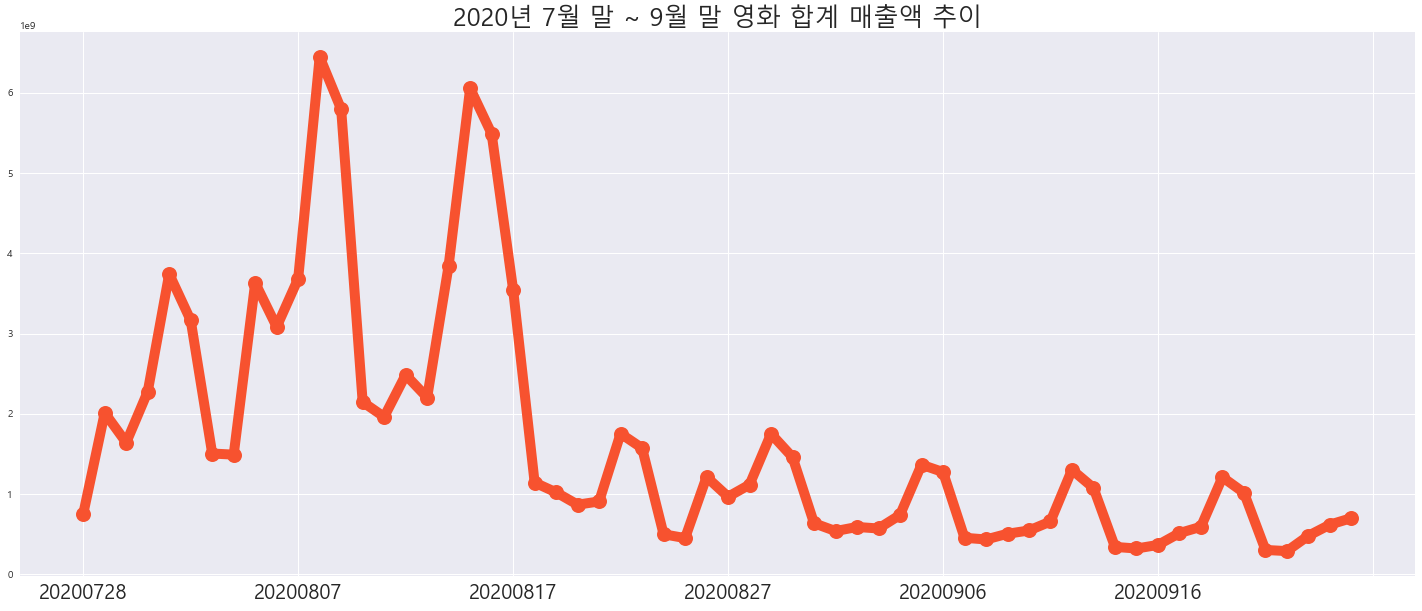

In [30]:
plt.figure(figsize=(25, 10))
aug2020_longterm['Sum'].plot(color="#F7522F", linewidth=10, marker='o', markersize=15)
plt.title("2020년 7월 말 ~ 9월 말 영화 합계 매출액 추이", fontsize=25)
plt.tick_params(axis='x', labelsize=20)

→ __8월 17일 이후 영화 매출액이 급락__했으며, 이 때 __떨어진 매출액은 9월 말까지도 꾸준히 이어졌음__을 알 수 있다. 코로나19 2차 대유행 시기 중 가장 많은 신규 확진자가 나왔던 __8월 27일이 아닌 그 이전부터 매출액은 하락세__를 띠었다는 것을 말해주는 결과다. 

조사 결과, 8월 16일부터 서울 경기 지역에서는 __사회적 거리두기__ 2단계가 실시되었다고 한다. 이와 더불어 코로나 확산이 우려되었던 __'광복절 집회'로 인해 사회적으로 공포심이 형성된 시기__였기도 하다. 이 때문에 영화관을 찾는 고객의 수가 8월 27일 이전부터 줄었을 것이다. 

그렇다면 코로나19 2차 대유행 시기에는 어떤 영화들이 개봉했는지, 어떤 장르가 흥행했는지 추가적으로 알아보자.

#### 2020년 8월 13일 ~ 9월 9일 영화별 매출액

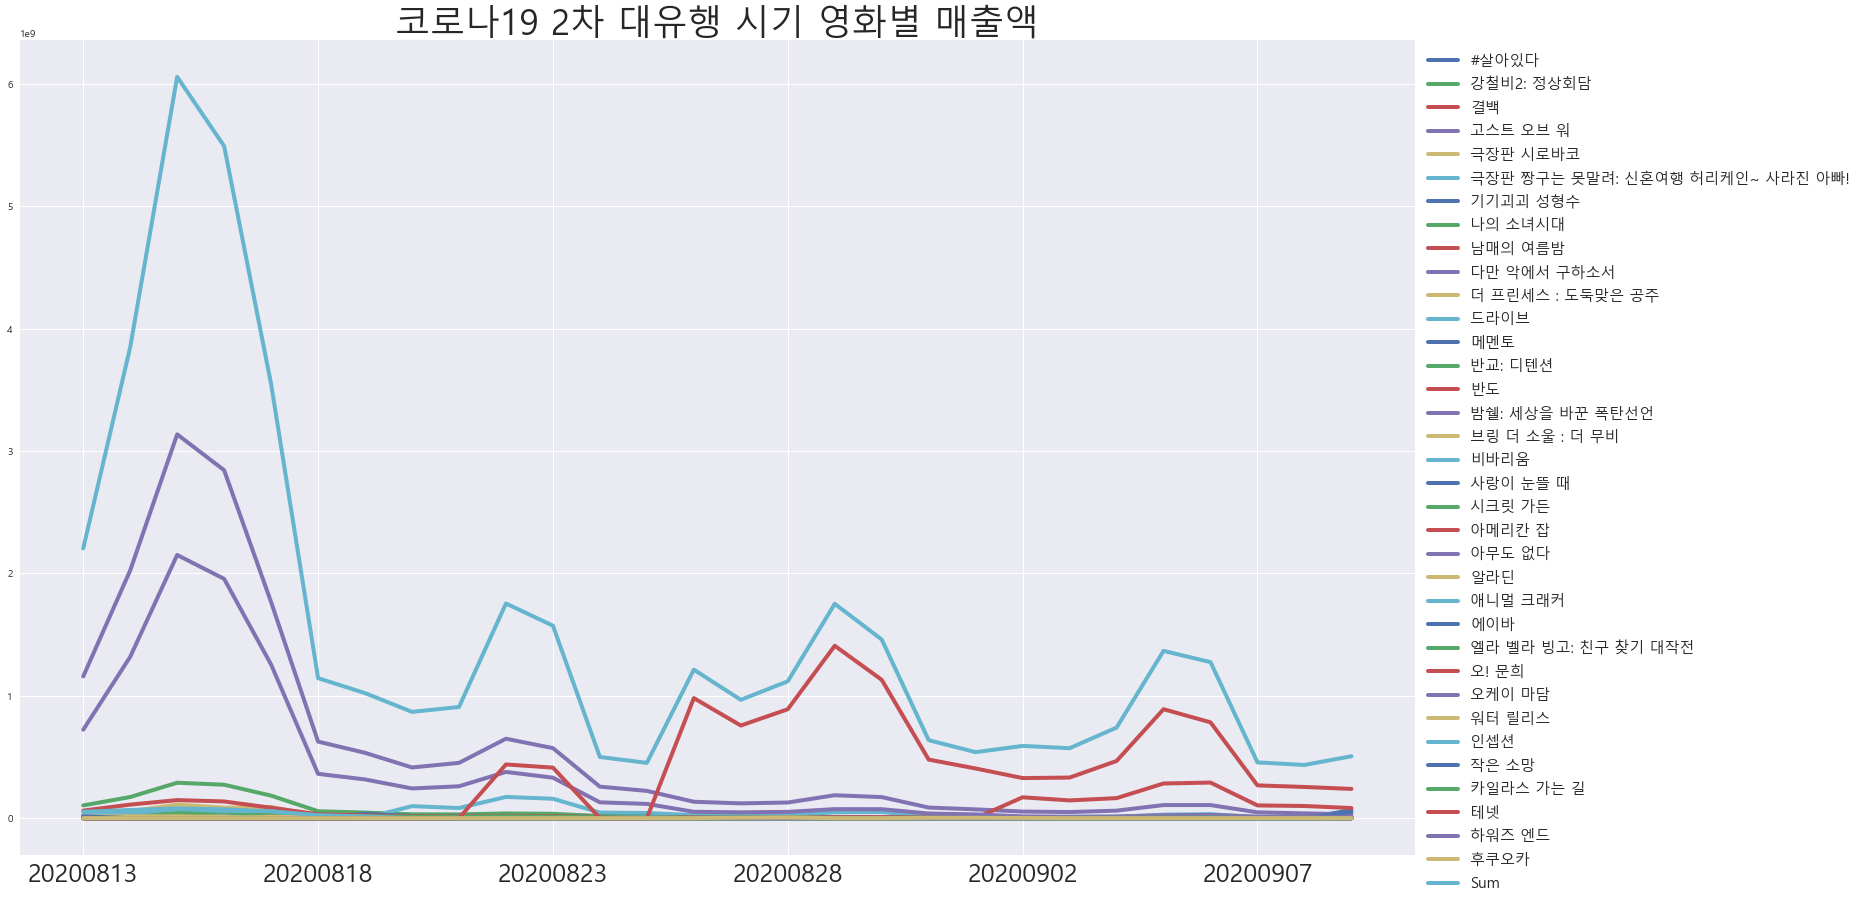

In [31]:
plt.rcParams["figure.figsize"] = (25, 15)
aug2020.plot(linewidth=4)
plt.title("코로나19 2차 대유행 시기 영화별 매출액", fontsize=35)
plt.tick_params(axis='x', labelsize=25)
plt.legend(bbox_to_anchor=(1, 1), fontsize=15)

가장 위에 나타난 하늘색 그래프는 Sum, 즉 총 매출액을 나타내는 선이다. 매출액이 0에서 3,000,000,000원인 구간을 확대해서 다시 시각화해보자.

(0, 3000000000)

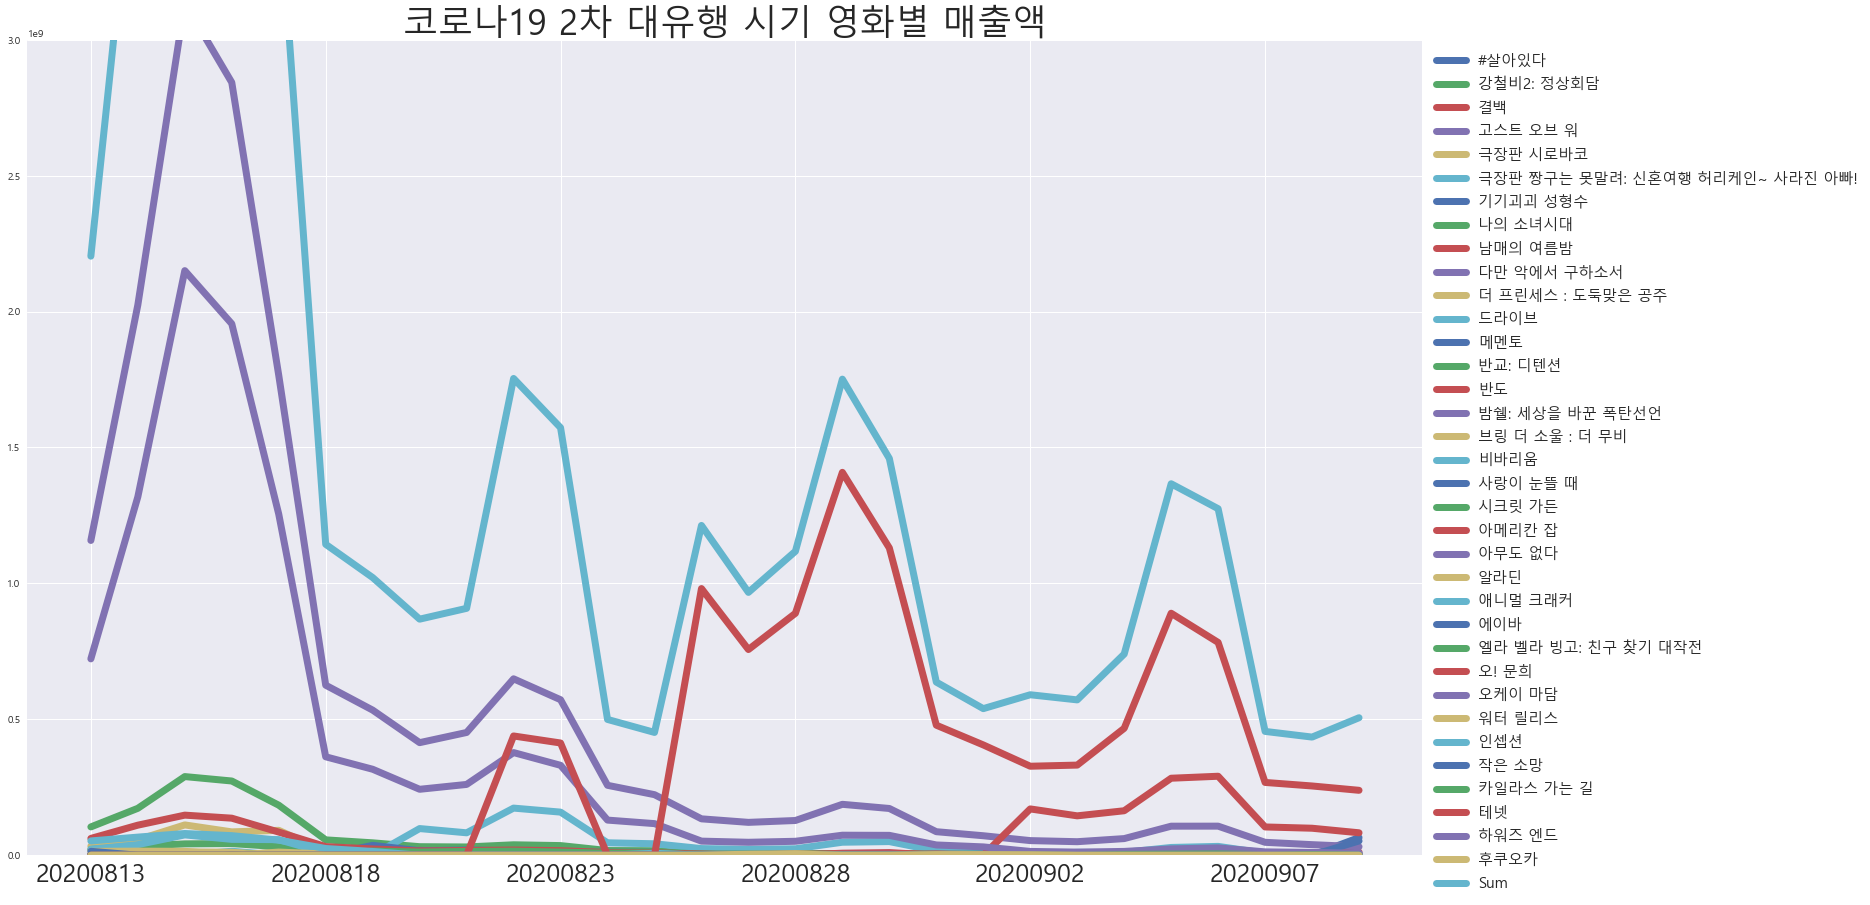

In [32]:
plt.rcParams["figure.figsize"] = (25, 15)
aug2020.plot(linewidth=7)
plt.title("코로나19 2차 대유행 시기 영화별 매출액", fontsize=35)
plt.tick_params(axis='x', labelsize=25)
plt.legend(bbox_to_anchor=(1, 1), fontsize=15)
plt.ylim([0, 3000000000]) 

→ 2020년 8월 13일부터 9월 9일까지 __상영된 영화는 총 35편__으로, 2019년의 29편보다 더 많은 편수이다. 이 중 __재개봉 영화는 총 7편__이다 ("나의 소녀시대", "드라이브", "메멘토", "브링 더 소울: 더 무비", "알라딘", "인셉션", "하워즈 엔드"). 

"다만 악에서 구하소서"와 "오케이 마담"이 나란히 매출액 1, 2위를 달리다가 __8월 22일 "테넷"이 개봉__하면서 매출이 급감했다. "오! 문희"가 9월 초 매출액 2위를 기록하며 치고올라오긴 했지만 전반적으로 __"테넷"의 독보적인 흥행__을 확인할 수 있다.

"테넷"의 그래프를 보면 8월 24일과 25일에 매출액이 0원으로 나타난다. 이는 "테넷"의 정식 국내개봉일이 8월 26일이었으나 22일과 23일, __프리미어 상영(선개봉)__이라는 특이한 방식으로 국내 개봉을 했었기 때문이다. __"테넷"은 코로나 이후 개봉한 첫 할리우드 텐트폴 영화__였다. 프리미어 상영이라는 개봉 방식은 더욱 많은 관객들을 극장으로 모으기 위해 택한 전략이라고 한다. 하지만 세계 영화 팬들이 뽑은 2020년 최고 기대작이었던 __"테넷"도 코로나의 타격을 피해갈 순 없었던 것__으로 보인다. 코로나19가 하반기에 재확산하면서 사회적 거리두기가 강화되었고, "테넷"은 기대보다 낮은 매출액을 기록했다는 뉴스기사가 많이 보도되었다. 

---------

#### (3) 코로나 3차 대유행 시기 - 2020.12.25. 기점으로 전후 14일 비교

#### 2020년 12월 11일 ~ 2021년 1월 7일 데이터 불러오기

In [33]:
dec2020 = create_a_kobis_df(14, 20201225)

dec2020

,100% 울프: 푸들이 될 순 없어,800,걸,굿바이,극장판 바이올렛 에버가든,나이팅게일,"내 어깨 위 고양이, 밥 2",더 프롬,덩케르크,도굴,디바,라라랜드,러브 액츄얼리,러브레터,럭키 몬스터,런,레벨 16,리플레이,마리 퀴리,미드나이트 스카이,미스터 보스,미스터 존스,뱅가드,비긴 어게인,빅풋 주니어2: 패밀리가 떴다,산티아고의 흰 지팡이,소년시절의 너,소울,썸머 85,언플랜드,에이바,완벽한 가족,원더 우먼 1984,이웃사촌,인터스텔라,조제,증발,파티마의 기적,퍼스트 러브,프리키 데스데이 순한맛,호프,화양연화,Sum
20201211,0,14095000,0,0,0,0,0,4480200,5328000,31191690,0,0,0,0,0,20406160,0,0,0,6306190,0,0,0,0,0,0,0,0,0,0,0,0,0,60859020,5619000,144930120,0,4052200,0,0,0,0,297267580
20201212,0,19588000,0,0,0,0,0,7022420,5760000,45543880,0,0,0,0,0,38917750,5634870,0,0,11233710,0,0,0,0,0,0,0,0,0,0,0,0,0,81524570,9185000,205149130,0,0,0,0,0,0,429559330
20201213,0,18794000,0,0,0,0,0,7253170,7940000,46433140,0,0,0,0,0,36150690,0,0,0,9380800,0,0,0,0,0,0,0,0,0,0,0,0,0,79510060,7319000,171426940,0,0,0,5384390,0,0,389592190
20201214,0,7409000,0,0,0,0,0,0,3380000,22095940,0,0,0,0,0,14080330,2080500,0,0,3874350,0,0,0,0,0,0,0,0,0,0,0,0,0,27145650,4460000,70107140,0,1920500,0,0,0,0,156553410
20201215,0,6754000,0,0,0,0,0,2051600,2649500,21593730,0,0,0,0,0,13345200,0,0,0,3371370,0,0,0,0,0,0,0,0,0,0,0,0,0,24675770,3049500,63418390,0,1963100,0,0,0,0,142872160
20201216,0,9282000,0,0,0,0,0,0,4060000,24000510,2878000,0,8150530,0,0,13662370,0,4897780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25092000,0,67835170,2464500,0,0,0,0,0,162322860
20201217,0,0,0,0,8223530,0,0,0,0,24074250,0,0,7211930,0,0,12648220,0,7699290,0,0,0,0,0,0,0,0,5150000,0,0,10115440,0,0,0,24088910,0,60073050,0,0,6075140,0,0,0,165359760
20201218,0,5429000,0,0,0,0,0,0,0,29945800,0,0,9420630,0,0,17437820,0,8898830,0,0,0,0,0,0,0,0,3130000,0,0,10402010,0,0,0,25182090,0,68846520,0,0,0,0,3708510,0,182401210
20201219,0,9356500,0,0,0,0,0,0,0,52275740,0,0,16838940,0,0,26589620,0,13533030,0,0,0,0,0,0,0,0,0,0,0,15492370,0,0,0,52476760,5570000,116604570,0,0,0,0,6024250,0,314761780
20201220,0,9432000,0,0,0,0,0,0,5230000,49374980,0,0,16146040,0,0,23308860,0,12387910,0,0,0,0,0,0,0,0,0,0,0,13726420,0,0,0,53856370,0,104218990,0,0,0,0,4812470,0,292494040


In [34]:
print("4주간 상영된 영화는 총", len(dec2020.columns) - 1, "편")

4주간 상영된 영화는 총 42 편


#### 2020년 12월 11일 ~ 2021년 1월 7일 합계 매출액 추이

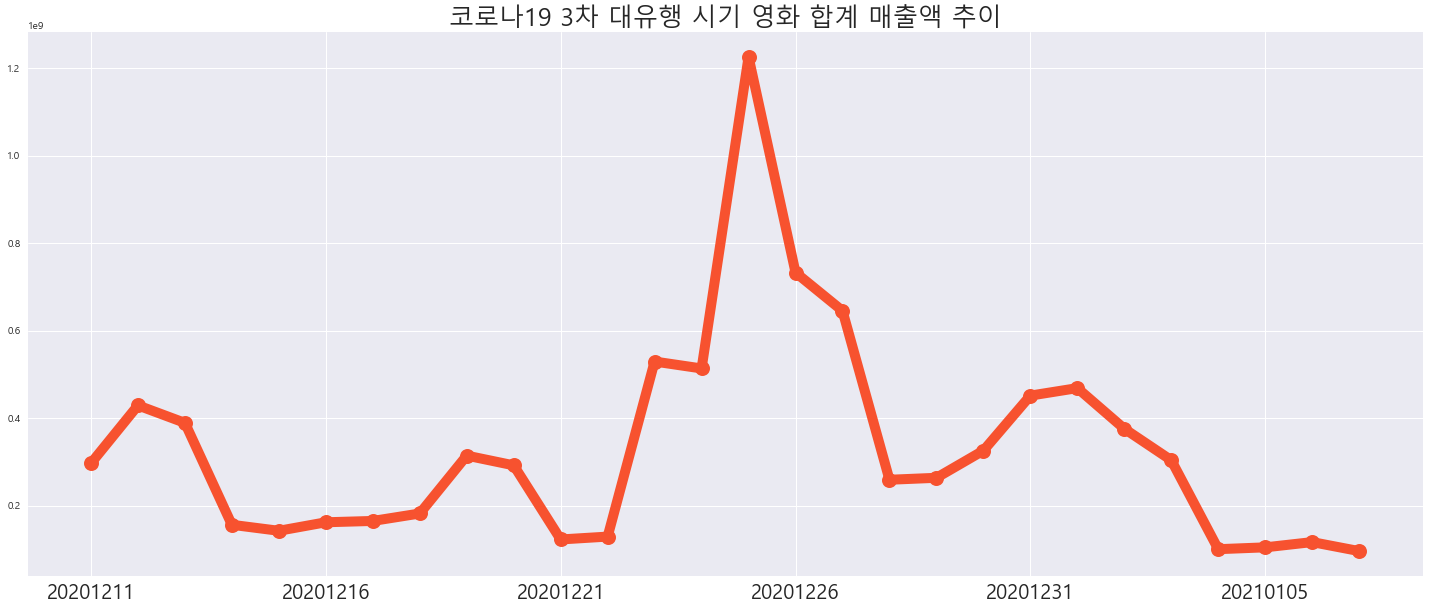

In [35]:
plt.figure(figsize=(25, 10))
dec2020['Sum'].plot(color="#F7522F", linewidth=10, marker='o', markersize=15)
plt.title("코로나19 3차 대유행 시기 영화 합계 매출액 추이", fontsize=25)
plt.tick_params(axis='x', labelsize=20)

→ __2020년 12월 25일(코로나19 신규 확진자가 1,240명으로 최고치 기록한 날)__부터 2주간의 총 매출액은 __직전 2주보다 42.99% 상승__한 것으로 드러났다. __1차 대유행 시기에는 매출액 "하락률"이 68.74%, 2차에는 59.42%__였던 점과는 상반된 결과다. 확진자 수가 가장 많이 나왔던 __12월 25일 당일은 오히려 가장 높은 매출액을 기록__했다. 크리스마스였기 때문에 평소보다 매출액이 높을 수 밖에 없는 상황이었다는 점을 감안하더라도, 확진자 수가 가장 많았다고 보도된 날 매출액이 이렇게나 높았다는 점이 흥미롭다.  

    12월 11일 ~ 12월 24일 (총 14일간) : 합계 매출액 3,829,652,830원 

    12월 25일 ~ 1월 7일 (총 14일간) : 합계 매출액 5,475,891,380원   
    
이런 매출액 패턴을 __평년과 비교해보기 위해 2019년 데이터__를 가져와보자. 

#### 2019년 12월 11일 ~ 2020년 1월 7일 데이터 불러오기

In [36]:
dec2019 = create_a_kobis_df(14, 20191225)

dec2019

,21 브릿지: 테러 셧다운,감쪽같은 그녀,겨울왕국 2,나이브스 아웃,눈의 여왕4,라스트 크리스마스,미드웨이,"미안해요, 리키",백두산,블랙머니,시동,신비아파트 극장판 하늘도깨비 대 요르문간드,아내를 죽였다,아스테릭스: 마법 물약의 비밀,쥬만지: 넥스트 레벨,천문: 하늘에 묻는다,카운트다운,캣츠,파비안느에 관한 진실,포드 V 페라리,프란치스코 교황 : 맨 오브 히스 워드,프린스 코기,해치지않아,Sum
20191211,0,149835040,971358580,166048590,0,74213720,0,0,0,32531940,99130000,0,132199500,0,860453620,0,20376000,0,0,318075160,0,0,0,2824222150
20191212,0,134336660,917228200,149253170,0,64257340,0,0,0,27942540,32142000,0,100381580,0,713405200,0,69466500,0,0,304730720,0,0,0,2513143910
20191213,0,151928320,1519292960,223538790,0,77506380,0,0,0,36737840,26823000,0,114906640,0,983747300,0,105961000,0,0,449564160,0,0,0,3690006390
20191214,0,206290120,3410349040,445102980,0,105258500,0,0,0,45832200,50414900,0,139623720,0,2259351130,0,129055500,0,0,908973180,0,0,0,7700251270
20191215,0,193561640,2761196180,424009540,0,87410560,0,0,0,43663860,35224620,0,125335500,0,1942863600,0,113369500,0,0,845814310,0,0,0,6572449310
20191216,0,99468700,653505870,204247750,0,44283120,0,0,0,19852880,0,0,51900740,0,445454090,27854000,49620500,0,0,304565720,0,0,0,1900753370
20191217,0,112598580,753642650,215350170,0,51112500,0,0,0,25077780,0,0,51372800,0,436827060,30194000,53213000,0,0,311619000,0,0,0,2041007540
20191218,0,38024560,619556910,139501280,0,21343920,0,0,71269000,0,1843357430,0,31643380,0,247251340,10222000,0,0,0,221062380,0,0,0,3243232200
20191219,0,12784920,423444640,56670300,0,0,0,19394080,3549081870,0,1092421530,171126580,0,0,85081390,5447000,0,0,0,93043850,0,0,0,5508496160
20191220,0,9647460,591971630,86287720,0,0,0,15133280,3651374520,0,1429877660,151305580,0,6380000,121769120,0,0,0,0,153929180,0,0,0,6217676150


In [37]:
print("4주간 상영된 영화는 총", len(dec2019.columns) - 1, "편")

4주간 상영된 영화는 총 23 편


#### 2019년과 2020년 매출액 비교

In [38]:
dec2019sum = dec2019['Sum'].sum()
dec2020sum = dec2020['Sum'].sum()

print("2019년 매출액 :", dec2019sum)
print("2020년 매출액 :", dec2020sum)

print("19년 대비 20년 매출액 변화 :", (dec2020sum - dec2019sum) / dec2019sum * 100, "%")

2019년 매출액 : 171590284890.0
2020년 매출액 : 9305537210.0
19년 대비 20년 매출액 변화 : -94.57688573920987 %


→ 앞서 살펴본 2월 ~ 3월 데이터에서는 -71.11%, 8월 ~ 9월 데이터에서는 -66.81%



#### 2019년 12월 11일 ~ 2020년 1월 7일 합계 매출액 추이

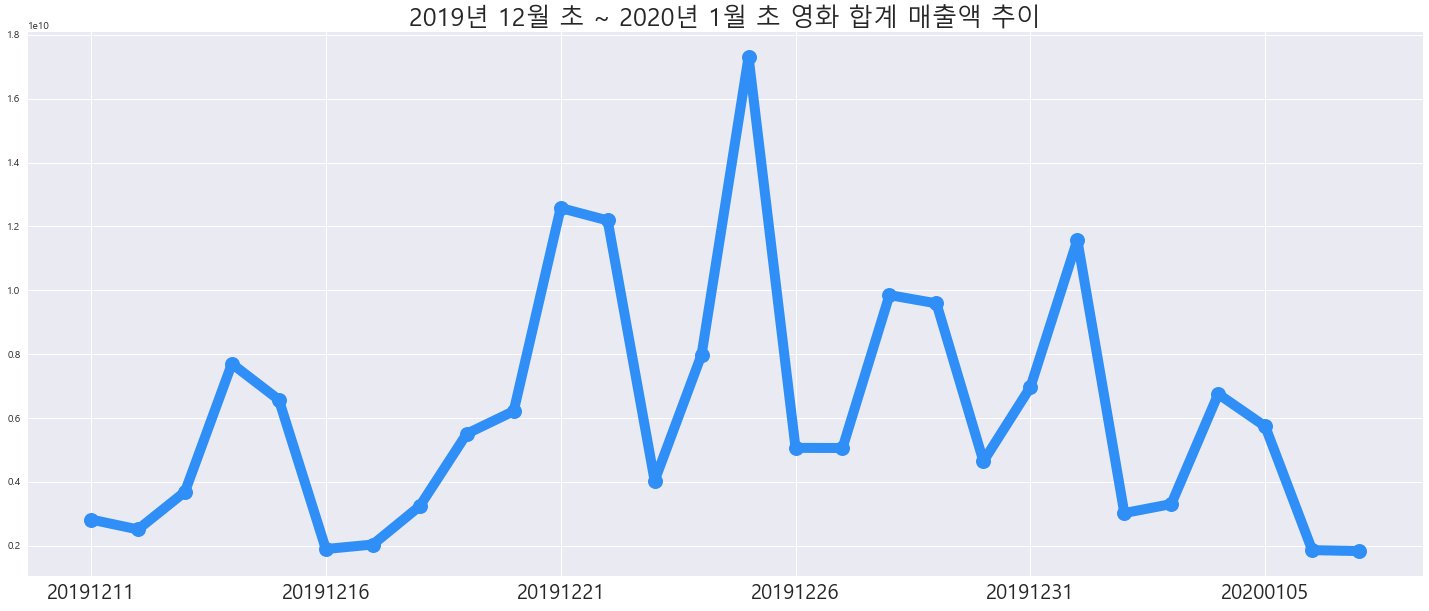

In [39]:
plt.figure(figsize = (25, 10))
dec2019['Sum'].plot(color="#2F8FF7", linewidth=10, marker='o', markersize=15)
plt.title("2019년 12월 초 ~ 2020년 1월 초 영화 합계 매출액 추이", fontsize=25)
plt.tick_params(axis='x', labelsize=20)

→ __2019년 12월 25일부터 2주간의 총 매출액은 직전의 2주보다 17.21% 상승__했다. 2020년의 경우 42.99% 상승률을 보였었는데, 다른 날들에 비해 크리스마스에만 유독 매출액이 높았던 점이 2019년도와는 다르다. 또, 절대적인 __매출액에서의 차이(19년 대비 20년 매출액 변화: -94.58%)가 1차, 2차 대유행 시기에 비해 매우 크다__는 점도 흥미롭다. 2019년 12월 그래프는 주중과 주말의 구분이 잘 없고, __매출액이 올라갔다 내려갔다 하는 패턴이 반복__되어 나타난다. 

    12월 11일 ~ 12월 24일 (총 14일간) : 합계 매출액 78,999,141,370원 

    12월 25일 ~ 1월 7일 (총 14일간) : 합계 매출액 92,591,143,520원   
    
보다 객관적인 결론을 위해 최근 3개년(2017, 2018, 2019) 데이터를 함께 비교해보자.

#### 같은 방법으로 2017년과 2018년 데이터 불러오기

In [40]:
dec2017 = create_a_kobis_df(14, 20171225)
dec2018 = create_a_kobis_df(14, 20181225) 

dec2017sum = dec2017['Sum'].sum()
dec2018sum = dec2018['Sum'].sum()

#### 2017년 ~ 2020년 합계 매출액 추이 비교

2017년 매출액 : 207721586040.0
2018년 매출액 : 158751126959.0
2019년 매출액 : 171590284890.0
2020년 매출액 : 9305537210.0


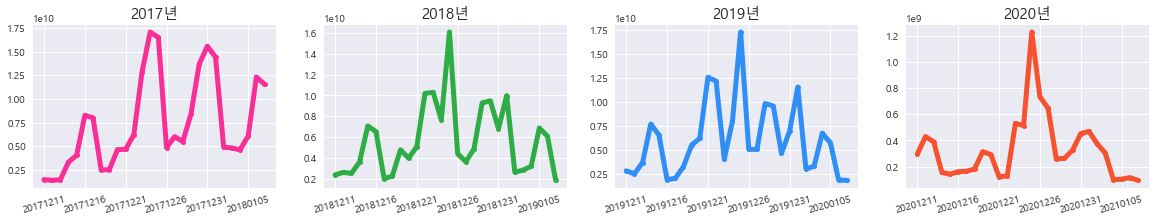

In [41]:
plt.figure(figsize=(20, 3))

plt.subplot(141)
dec2017['Sum'].plot(color="#F72F96", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2017년", fontsize=15)

plt.subplot(142)
dec2018['Sum'].plot(color="#2EAD46", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2018년", fontsize=15)

plt.subplot(143)
dec2019['Sum'].plot(color="#2F8FF7", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2019년", fontsize=15)

plt.subplot(144)
dec2020['Sum'].plot(color="#F7522F", linewidth=5, marker='o', markersize=5, rot=15)
plt.title("2020년", fontsize=15)

print("2017년 매출액 :", dec2017sum)
print("2018년 매출액 :", dec2018sum)
print("2019년 매출액 :", dec2019sum)
print("2020년 매출액 :", dec2020sum)

→ 2017년, 2018년, 2019년, 2020년 모두 __크리스마스 당일에 가장 높은 매출액__을 기록했다. 17년부터 19년도 그래프의 공통적인 특징은, 12월 25일 전후로는 __다른 시즌에 비해 매출액이 심하게 오르락 내리락__ 하는 패턴을 띤다는 점이다.  

이에 비해 2020년도 그래프를 보면, 12월 25일을 제외한 나머지 날들에서는 날짜별로 매출액의 차이가 그렇게 크지 않다. 또한 __2020년 매출액은 평년에 비해 굉장히 낮다__는 점을 확인했다. 

__코로나 3차 대유행 시기에는 어느 시점부터 영화 매출액이 급감했는지__ 알아보기 위해 좀 더 __장기적인 데이터__를 불러와 확인봐야 할 것이다.

#### 2020년 11월 25일 ~ 2021년 1월 23일 데이터 불러오기

In [42]:
dec2020_longterm = create_a_kobis_df(30, 20201225)

dec2020_longterm

,#아이엠히어,100% 울프: 푸들이 될 순 없어,800,가나의 혼인잔치: 언약,가을의 마티네,걸,굿바이,그리고 우린 춤을 추었다,그린랜드,극장판 귀멸의 칼날: 무한열차편,극장판 기븐,극장판 바이올렛 에버가든,나는 나를 해고하지 않는다,나이팅게일,"내 어깨 위 고양이, 밥 2",내가 죽던 날,늑대와 춤을,더 시크릿,더 프롬,덩케르크,도굴,디바,라라랜드,라스트 프론티어,래시 컴 홈,러브 액츄얼리,러브레터,럭키 몬스터,런,레벨 16,로그,리플레이,마리 퀴리,마이 미씽 발렌타인,모추어리 컬렉션,미드나이트 스카이,미스터 보스,미스터 존스,뱅가드,블라인드,비긴 어게인,빅풋 주니어2: 패밀리가 떴다,빛의 아버지: 파이널 판타지 XIV,산티아고의 흰 지팡이,삼진그룹 영어토익반,세자매,소년시절의 너,소울,스웨그,썸머 85,아이 엠 우먼,안티고네,언플랜드,에이바,완벽한 가족,요가학원 : 죽음의 쿤달리니,원더 우먼 1984,이웃사촌,인터스텔라,잔칫날,조제,증발,지옥의 묵시록 파이널 컷,추억의 검정고무신,커넥트,테넷,파티마의 기적,파힘,퍼스트 러브,페이트 스테이 나이트 헤븐즈필 제3장 스프링 송,프리키 데스데이,프리키 데스데이 순한맛,호프,화양연화,Sum
20201125,0,0,0,0,0,0,0,0,5177000,0,0,3896280,0,0,0,12116950,0,0,0,0,83259530,0,0,0,0,0,0,0,60778230,0,5267780,0,0,0,0,0,0,0,0,0,0,0,0,0,20161240,0,0,0,0,0,0,4623900,0,0,0,0,0,233197720,0,0,0,0,0,0,0,0,0,0,0,0,58775040,0,0,0,487253670
20201126,0,0,0,0,0,0,0,6032570,0,0,7655970,20613530,0,0,0,9470150,0,0,0,0,60224870,0,0,0,0,0,0,0,52212860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13266230,0,0,0,0,0,0,0,0,0,0,0,0,204032710,0,0,0,0,0,0,0,0,0,0,0,13660340,44344850,0,0,0,431514080
20201127,0,0,0,4967240,0,0,0,3793980,0,0,0,8268850,0,0,0,8233280,0,0,0,0,72265280,0,0,0,0,0,0,0,78052660,0,0,0,2935870,0,0,0,0,0,0,0,0,0,0,0,15212090,0,0,0,0,0,0,0,0,0,0,0,0,241683560,0,0,0,0,0,0,0,0,0,0,0,0,46849900,0,0,0,482262710
20201128,0,0,0,6963400,0,0,0,0,0,0,0,10607370,0,0,0,14564160,0,0,0,0,145338650,0,0,0,0,0,0,0,140032530,0,0,0,5274670,0,0,0,0,0,0,0,0,0,0,0,30859240,0,0,0,0,0,0,0,0,0,0,0,0,461237510,0,0,0,0,0,7740000,0,0,0,0,0,0,74716160,0,0,0,897333690
20201129,0,0,0,7713240,0,0,0,0,0,0,0,8270860,0,0,0,14791510,0,0,0,0,159294730,0,0,0,0,0,0,0,122989360,0,0,0,6507470,0,0,0,0,0,0,0,0,0,0,0,30093090,0,0,0,0,0,0,0,0,0,0,0,0,415879080,0,0,0,0,0,6085500,0,0,0,0,0,0,66757660,0,0,0,838382500
20201130,0,0,0,5183610,0,0,0,4312270,0,0,0,3325980,0,0,0,10940260,0,0,0,0,79685160,0,0,0,0,0,0,0,58588320,0,2741470,0,0,0,0,0,0,0,0,0,0,0,0,0,15470100,0,0,0,0,0,0,0,0,0,0,0,0,168455280,0,0,0,0,0,0,0,0,0,0,0,0,27447010,0,0,0,376149460
20201201,0,0,0,5725800,0,0,0,3183970,0,0,0,0,0,0,0,8973720,0,0,0,0,50167870,0,0,0,0,0,0,0,45973740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12348320,0,0,0,0,0,0,0,0,0,0,2926000,0,127434060,0,0,0,0,2960500,0,0,0,0,0,0,0,22040760,0,0,0,281734740
20201202,0,0,0,4870470,0,0,0,0,0,0,0,0,0,0,0,3910910,0,0,41590400,0,44790700,0,0,0,0,0,0,0,42183380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8718250,0,0,0,0,0,0,0,0,0,0,0,0,117816010,0,10233470,3537000,0,0,0,0,0,0,0,0,0,15800950,0,0,0,293451540
20201203,0,0,0,0,0,0,0,0,0,0,0,17330430,0,0,0,0,0,0,25969370,0,45419050,0,0,0,0,0,0,0,41315160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,115966910,13450000,10421940,0,0,0,0,0,0,21576900,0,0,7918820,12353340,0,0,0,311721920
20201204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26336210,6788500,53381470,0,0,0,0,0,0,0,49775000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7667090,0,0,0,0,0,0,0,0,0,0,0,0,118056470,8905000,9612640,0,0,0,0,0,0,14176600,0,0,0,13224050,0,0,0,307923030


#### 2020년 11월 25일 ~ 2021년 1월 23일 합계 매출액 추이

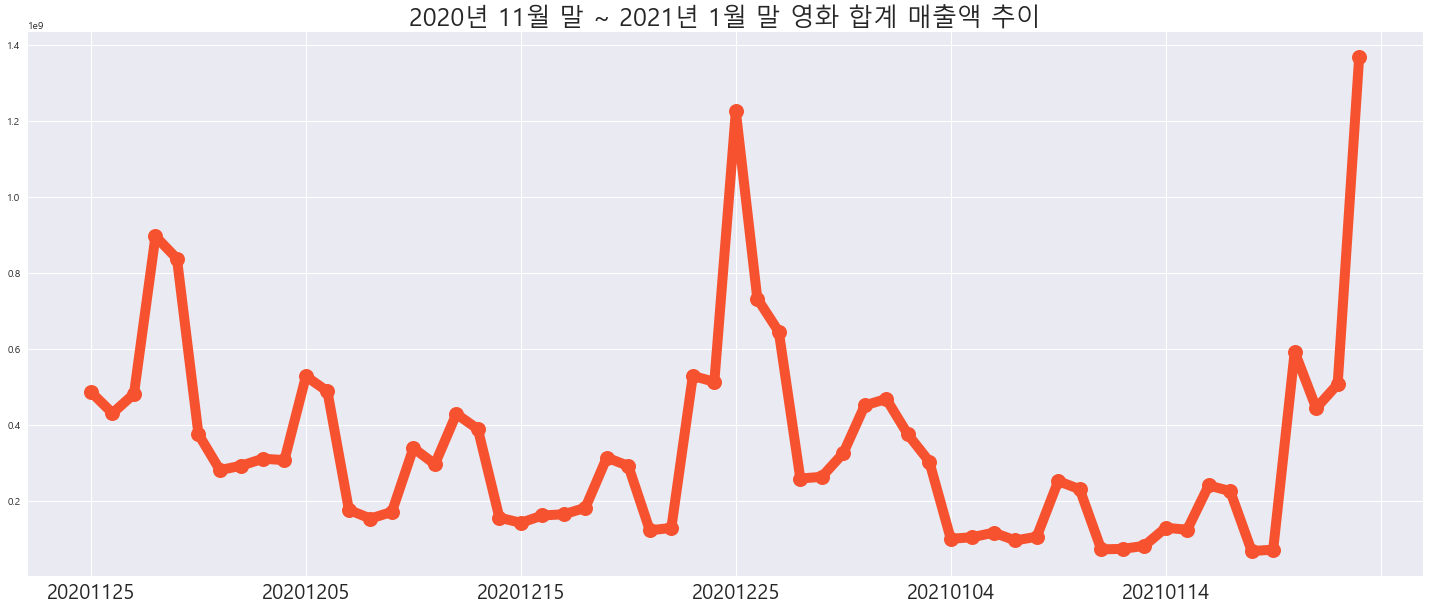

In [43]:
plt.figure(figsize=(25, 10))
dec2020_longterm['Sum'].plot(color="#F7522F", linewidth=10, marker='o', markersize=15)
plt.title("2020년 11월 말 ~ 2021년 1월 말 영화 합계 매출액 추이", fontsize=25)
plt.tick_params(axis='x', labelsize=20)

→ 그래프를 보면 __본격적인 코로나19 3차 대유행이 시작되기 이전인 11월 말부터 영화 매출액은 서서히 감소__했으며, __크리스마스 시즌에 일시적으로 증가했다가 이후 곧바로 다시 감소세__에 접어들었다는 점을 확인할 수 있다. __12월 25일 신규 확진자 수가 1,240명으로 역대 최다치를 기록한 다음 날에는 매출액이 크게 급감__했던 것을 알 수 있다. 

__2021년 1월 말부터는 일일 신규 확진자 수가 500명 이하로 떨어지면서 매출액이 다시 상승__하기 시작했다. __1월 20일에는 디즈니-픽사 애니메이션 "소울"__이 많은 이들의 기대를 안고 개봉하면서 __매출액 상승에 기여__했을 것이라고 생각된다. 

코로나19 3차 대유행 시기에는 어떤 영화들이 개봉했고 어떤 작품이 흥행에 성공했는지 살펴보자. 

#### 2020년 12월 11일 ~ 2021년 1월 7일 영화별 매출액

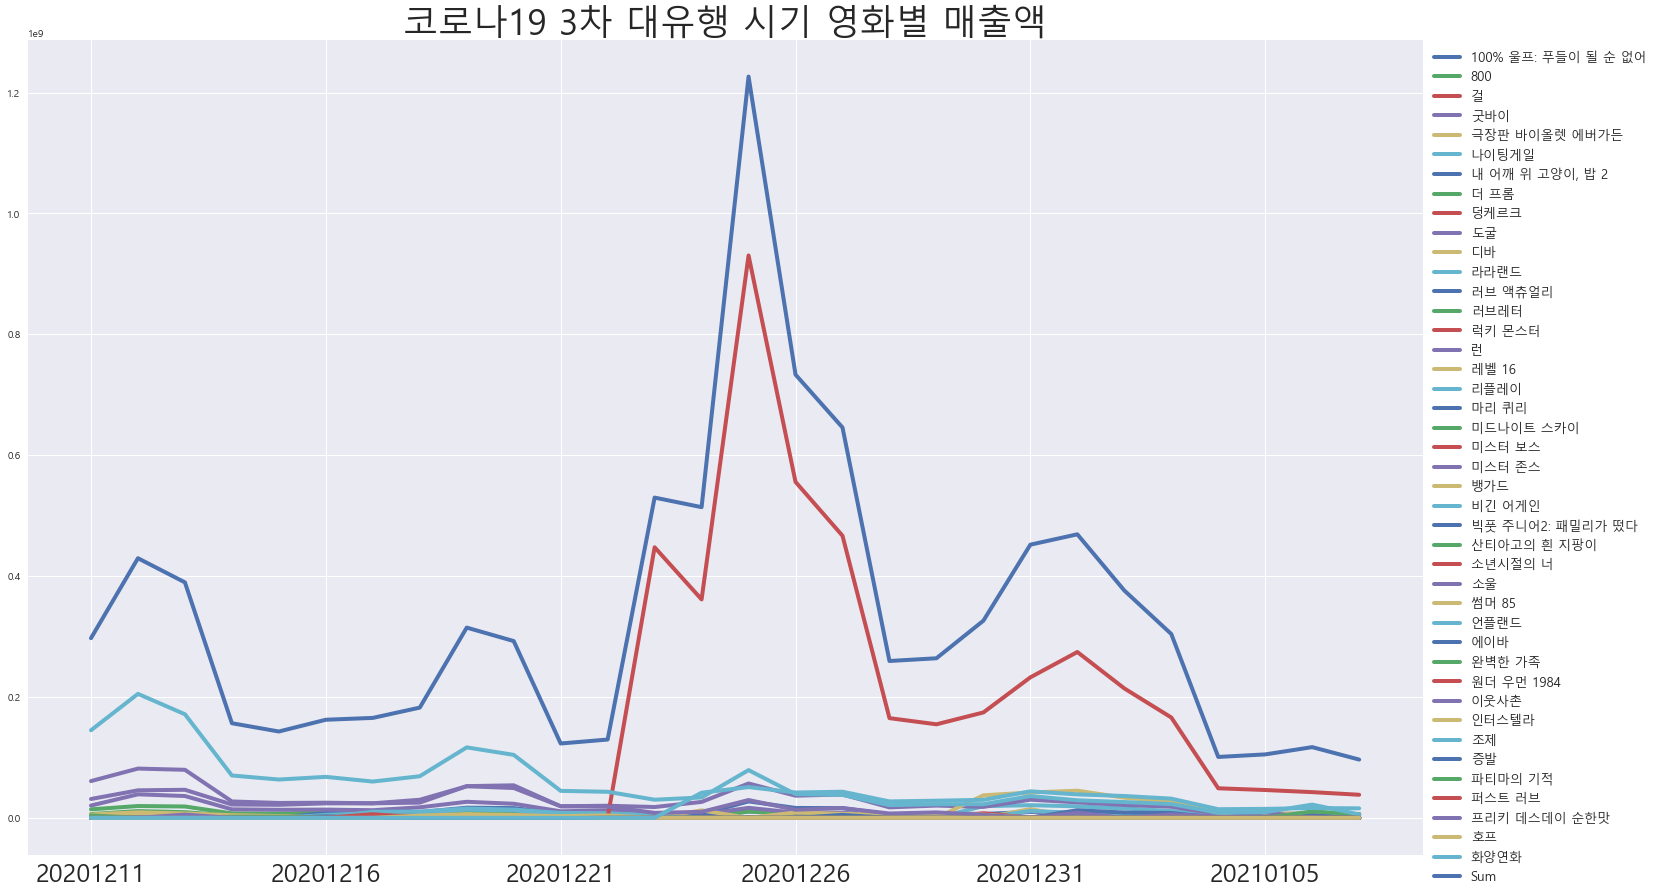

In [44]:
plt.rcParams["figure.figsize"] = (25, 15)
dec2020.plot(linewidth=4)
plt.title("코로나19 3차 대유행 시기 영화별 매출액", fontsize=35)
plt.tick_params(axis='x', labelsize=25)
plt.legend(bbox_to_anchor=(1, 1), fontsize=13)

가장 위에 나타난 파란색 그래프가 Sum, 즉 총 매출액을 나타내는 선이다. 매출액이 0에서 1,000,000,000원인 구간을 확대해서 다시 시각화해보자.

(0, 1000000000)

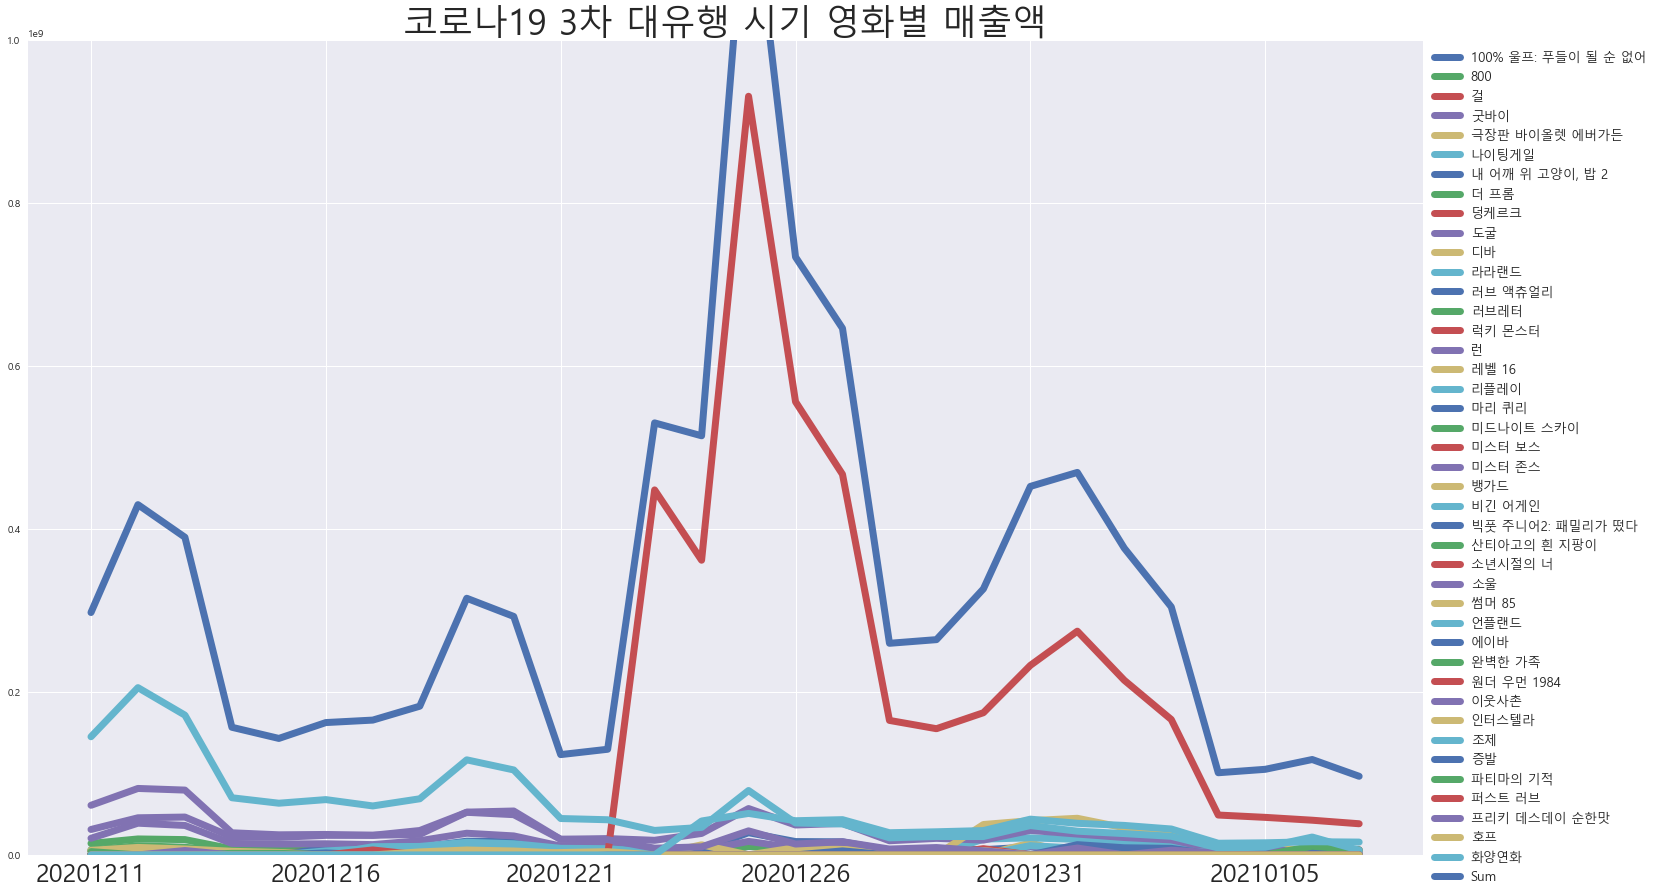

In [45]:
plt.rcParams["figure.figsize"] = (25, 15)
dec2020.plot(linewidth=7)
plt.title("코로나19 3차 대유행 시기 영화별 매출액", fontsize=35)
plt.tick_params(axis='x', labelsize=25)
plt.legend(bbox_to_anchor=(1, 1), fontsize=13)
plt.ylim([0, 1000000000])

→ 2020년 12월 11일부터 2021년 1월 7일까지 __상영된 영화는 총 42편__으로, 직전 해의 23편보다 훨씬 더 많은 편수이다. 하지만 이 중 __재개봉작이 총 8편__이었다 ("굿바이", "덩케르크", "라라랜드", "러브 액츄얼리", "러브레터", "비긴 어게인", "인터스텔라", "화양연화"). 

그래프를 보면 빨간선으로 나타난 __"원더우먼 1984"의 독보적인 흥행__을 확인할 수 있다. 일본영화를 리메이크한 한국영화 "조제"는 "원더우먼 1984"의 개봉 이후 저조한 매출을 기록하게 되었다. 그래프 상에서는 잘 나타나지 않지만 참고로 이 시기에는 "화양연화", "미스터 존스"와 같은 다수의 __예술영화들이 꽤 괜찮은 흥행__을 이루어냈다는 평가를 받기도 했다. 

----------

지금까지 코로나19 1차, 2차, 3차 대유행 시기 영화 매출액을 평년과 비교해보았는데, 이를 한눈에 비교해보기 위해 시각화해본다.

#### ● 코로나19 1차, 2차, 3차 대유행 시기의 영화 매출액 변화 비교

1차 대유행 시기 총 매출액 : 35603499140.0
2차 대유행 시기 총 매출액 : 42992591352.0
3차 대유행 시기 총 매출액 : 9305537210.0


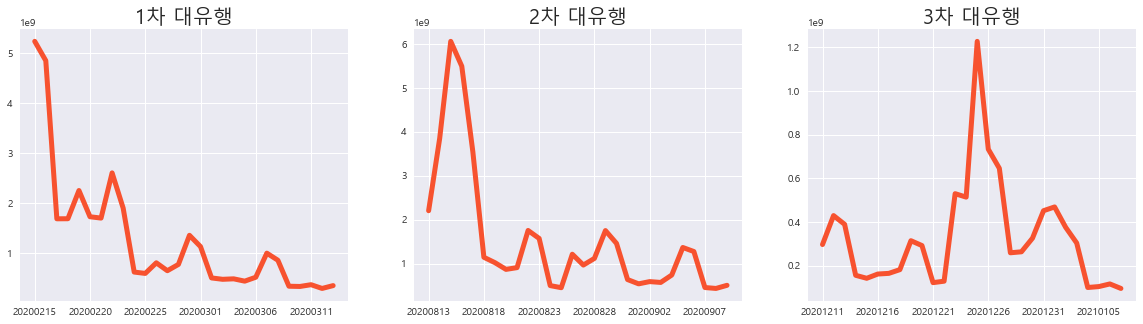

In [46]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
feb2020['Sum'].plot(color="#F7522F", linewidth=5)
plt.title("1차 대유행", fontsize=20)
plt.tick_params(axis='x', labelsize=10)

plt.subplot(132)
aug2020['Sum'].plot(color="#F7522F", linewidth=5)
plt.title("2차 대유행", fontsize=20)
plt.tick_params(axis='x', labelsize=10)

plt.subplot(133)
dec2020['Sum'].plot(color="#F7522F", linewidth=5)
plt.title("3차 대유행", fontsize=20)
plt.tick_params(axis='x', labelsize=10)

print("1차 대유행 시기 총 매출액 :", feb2020sum)
print("2차 대유행 시기 총 매출액 :", aug2020sum)
print("3차 대유행 시기 총 매출액 :", dec2020sum)

→ __총 매출액은 2차 대유행 시기에 가장 높았고, 1차에 그 다음으로 높았으며, 3차에는 1, 2차에 비해 몇 배나 저조__했다. 3차 대유행 시기에는 일일 신규 확진자 수가 1,000대를 돌파하면서 가장 많은 확진자가 나온 시기이기 때문일 것이다.

### - 가설 검증

앞서 제시했었던 가설을 데이터에 기반해서 검증해보려고 한다. 

(1) 코로나19 1, 2, 3차 대유행 시기의 영화 매출액을 전년도와 비교해보면 50% 이상 대폭 하락했을 것이다. 

→ __1차에는 -71.11%, 2차에는 -66.81%, 3차에는 -94.58%; 전년도에 비해 50% 이상 매출액이 하락__한 것을 확인했다. 

(2) 대유행 시기 중 일별 신규 확진자 수가 최고치를 기록한 직후에 영화 매출액이 가장 크게 급감했을 것이다.

→ 3차 대유행 시기의 경우, 신규 확진자 수가 최고치를 기록한 다음 날 영화 매출액이 크게 급감하긴 했지만, 나머지 1차와 2차 대유행에서는 그렇지 않았다. 오히려 일별 신규 확진자 수가 최고치를 기록하기 훨씬 이전부터 매출액은 감소세에 접어들었었다. 1차 시기에는 국내 코로나 확진자가 본격적으로 생겨나서 언론에 관련 보도가 많이 이루어지기 시작한 때, 2차에는 사회적 거리두기의 강화 및 광복절 집회로 인한 코로나 재확산 우려가 시작되던 때였다. 이를 통해, __코로나로 인한 영화 매출액 하락은 신규 확진자 수와도 어느 정도 관련은 있겠지만 언론 보도와 사회적 분위기에 더 크게 좌우된다__는 것을 알 수 있다. 

(3) 코로나19 대유행 시기의 영화 매출액 하락률을 서로 비교해보았을 때, 가장 큰 하락률을 보인 기간은 1차 > 2차 > 3차 순서일 것이다.

→ __1차에는 -68.74%, 2차에는 -59.42%, 3차에는 +42.99%; 3차 대유행 시기에 매출액이 감소하지 않고 오히려 증가했다__는 점이 인상적인 결과였다. 

### - 비즈니스 액션플랜 제시

코로나19 시기의 영화 박스오피스 매출 데이터를 분석하면서 도출된 결론을 바탕으로 몇 가지 액션플랜을 제시해보자면 다음과 같다.

(1) 코로나19 시기에 기존 영화들을 재개봉시키기보다 __관객들의 기대에 부응하는 다양한 영화들__이 제작되어야한다. 1, 2, 3차 대유행 시기에 재개봉 비율은 각각 16%, 20%, 19%로, 평년에 비해 높은 수치였다. 코로나19 일일 신규 확진자 수가 최고치를 기록한 날 전후로 2주간의 영화 매출액을 비교해보면, 1차 대유행 시기에서의 하락률이 약 70%로 가장 컸고, 2차 시기에는 약 60%로 조금 낮아졌으며, 3차의 경우에는 오히려 40% 이상 상승했다는 결과가 나타났다. 이는 시간이 경과할수록 코로나의 심각성에 익숙해진 사람들이 확진자 수에 상관하지 않고 영화관을 더 많이 찾게 되었다는 것을 말해준다. 이에 따라, 재개봉이라는 손쉬운 방법으로 매출액을 높이지 않고 적극적으로 다양한 영화가 제작되어 상영되었으면 좋겠다는 바람이다.    

(2) 코로나19 시기에는 __공포영화__에 주목해야한다. 공포영화는 즐겨찾는 매니아층이 확고하고, 타 장르에 비해 제작비도 적게 든다. 바이러스로 인해 공포스럽고 억압된 사회 분위기 속에서 사람들은 공포영화를 통해 카타르시스를 느끼게 된다는 연구결과도 많이 나왔다. 2020년 2월 ~ 3월에 매출액 1위를 기록한 저예산 공포영화 "인비저블맨"의 흥행이 좋은 예시이다. 또한, 코로나로 인해 많은 작품들이 개봉을 미뤄야만 할 때 대부분의 공포영화들은 예정대로 개봉했다고 한다. 따라서 코로나19 시기에 영화제작자들은 공포영화를 통해 관객들을 모으고 영화 매출을 높이는 방안을 고려하면 좋을 듯하다.

(3) 코로나19 시기에는 __독립영화, 예술영화 발굴__에 주목해야한다. "1917" 혹은 "테넷"과 같은 대작도 코로나의 타격을 피해갈 수 없었다는 사실을 통해, 요즘 같은 시기에 많은 예산을 들여 블록버스터 영화를 제작하는 것은 좋지 않은 선택이라는 것을 알 수 있다. 다수의 블록버스터 영화가 코로나로 인해 개봉을 미루고 있는 틈을 타 독립영화, 예술영화는 오히려 호황을 누릴 수 있는 상황이다. 2020년 여름에 개봉해 장기흥행에 성공한 독립영화 "남매의 여름밤", 20년 만에 재개봉해 예상보다 훨씬 많은 관객들을 끌어모았다고 평가되는 예술영화 "화양연화" 등만 보더라도 알 수 있다. 이런 독립, 예술영화들이 좀 더 극장에서 흥행할 수 있도록 제도 개선과 함께 재정적인 지원이 뒷받침되어야 한다고 생각한다.   

--------------------------------------------------------------------------------

*** 추후 더 해보고 싶은 것 : 
    
관객 수 분석 → 매출액 분석 결과와 어떤 차이가 있는지. 
                            
21년 1월 이후의 영화 매출액 데이터 분석.